## House Price Prediction Assignment

### Problem Statement:

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. 

We are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.


### Business Goals:

The company wants to know:
1. Which variables are significant in predicting the price of a house, and
2. How well those variables describe the price of a house.

Also, determine the optimal value of lambda for ridge and lasso regression.


### Steps:

#### 1. Data Sourcing

    1. Checking the encoding of the file
    2. Loading the data		

#### 2. Data Exploring & Cleaning

    A. Null Values Analysis
        1. Identify and drop columns with 100% missing data
        2. Identify and drop columns with more than 80% missing data
        3. Identify and drop columns having single unique values as they will not any value to the analysis
        4. Identify and drop unnecessary columns (like text based, Applicant Loan Behaviour)

    B. Datatype Check 

    C. Datatype Conversion
        1. Converting int to object
    
    D. Drop Records
        1. Drop Duplicates
    
    E. Impute Null Values
    
    F. Populating the categorical columns with correct mapping
    
    G. Outliers handling
    
    G. Derived Metrics
    
#### 3. Data Visualisation
#### 4. Data Preparation
#### 5. Splitting and Scaling the data
#### 6. Model Building & Evaluation
#### 7. Regualisation using Ridge and Lasso
#### 8. Making Predictions Using the Final Model on the test data
######################################################################

## Step 1: Data Sourcing

In [1]:
# Importing all required packages
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import cufflinks as cf
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from pandas.api.types import is_object_dtype,is_string_dtype, is_numeric_dtype

%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE,RFECV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 10000)
py.offline.init_notebook_mode(connected=True) # plotting in offilne mode 
cf.set_config_file(offline=False, world_readable=True, theme='ggplot')
pd.set_option('display.max_colwidth', 1) # make sure data and columns are displayed correctly withput purge
pd.options.display.float_format = '{:20,.2f}'.format # display float value with correct precision 

In [2]:
# Generic Functions

# Method to get Meta-Data about any dataframe passed 
def getMetadata(dataframe) :
    metadata_matrix = pd.DataFrame({
                    'Datatype' : dataframe.dtypes, # data types of columns
                    'Total_Element': dataframe.count(), # total elements in columns
                    'Null_Count': dataframe.isnull().sum(), # total null values in columns
                    'Null_Percentage': round(dataframe.isnull().sum()/len(dataframe) * 100,2) ,# percentage of null values
                    'Unique_Value': dataframe.nunique()
                       })
    return metadata_matrix

def getVIF(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

def binary_map(x):
    return x.map({'yes': 1, "no": 0})

def cross_validation(X_train,y_train,lm):
    folds = KFold(n_splits = 2, shuffle = True, random_state = 100)
    hyper_params = [{'n_features_to_select': list(range(len(X_train.columns)))}]
    lm.fit(X_train, y_train)
    rfe = RFE(lm)             
    model_cv = GridSearchCV(estimator = rfe, 
                            param_grid = hyper_params, 
                            scoring= 'r2', 
                            cv = folds, 
                            verbose = 1,
                            return_train_score=True)      

    model_cv.fit(X_train, y_train)                  
    cv_results = pd.DataFrame(model_cv.cv_results_)
    plt.figure(figsize=(16,6))
    plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
    plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
    plt.xlabel('number of features')
    plt.ylabel('r-squared')
    plt.title("Optimal Number of Features")
    plt.legend(['test score', 'train score'], loc='upper left')
    
def plot_bar_chart(plotting_frame,x_column,y_column) :
            
        x_axis_title = x_column.title()
        y_axis_title = y_column.title()
        
        graph_title = "Bar Chart [" + x_axis_title.title() + " Vs " + y_axis_title.title() + "]"
        
        layout = go.Layout(
             title = graph_title,
             yaxis=dict(
                title=y_axis_title
             ),
             xaxis=dict(
                 title=x_axis_title
             )
        )

        data_to_be_plotted = [
            go.Bar(
                x=plotting_frame[x_column], 
                y=plotting_frame[y_column]
            )
        ]


        figure = go.Figure(data=data_to_be_plotted,layout=layout)
        py.offline.iplot(figure)
        
        
def plot_pie_chart(plotting_frame,x_column,y_column) : 
        
        labels = plotting_frame[x_column].tolist()
        values = plotting_frame[y_column].tolist()

        trace = go.Pie(labels=labels, values=values)

        py.offline.iplot([trace])

        
def plot_box_chart(dataframe) :
    data = []
    for index, column_name in enumerate(dataframe) :
        data.append(
        go.Box(
            y=dataframe.iloc[:, index],
            name=column_name
         ))   
        
    layout = go.Layout(
    yaxis=dict(
        title="Frequency",
        zeroline=False
    ),
       boxmode='group'
    )
    
    fig = go.Figure(data=data, layout=layout)    
    py.offline.iplot(fig) 
    
def plot_group_bar_chart(plot,col,hue) : 
    hue_col = pd.Series(data = hue)
    fig, ax = plt.subplots()
    width = len(plot[col].unique()) + 6 + 5*len(hue_col.unique())
    fig.set_size_inches(width , 10)
    ax = sns.countplot(data = loan_plot, x= col, order=plot[col].value_counts().index,hue = hue,palette="Set2") 
    
    for p in ax.patches:
                # Some segment wise value we are getting as Nan as respective value not present to tackle the Nan using temp_height
                temp_height = p.get_height()
                
                if math.isnan(temp_height):
                    temp_height = 0.01
                    
                
                ax.annotate('{:1.1f}%'.format((temp_height*100)/float(len(loan_plot))), (p.get_x()+0.05, temp_height+20)) 
    
    plt.show()

def col_list(df):
    num_list = []
    cat_list = []
    for column in df:
        if is_numeric_dtype(df[column]):
            num_list.append(column)
        elif is_object_dtype(df[column]):
            cat_list.append(column)    
    return cat_list,num_list

def outliers(df,num_list):
    oc = []
    noc=[]
    l=[]
    u=[]
    for c in num_list:
        data=df[c].values
        lower, upper = np.mean(data) - (np.std(data) * 3), np.mean(data) + (np.std(data) * 3)
        outliers=len([x for x in data if x < lower or x > upper])
        non_outliers=len([x for x in data if x >= lower and x <= upper])
        l.append(lower)
        u.append(upper)
        oc.append(outliers)
        noc.append(non_outliers)
    oc_metric = pd.Series(oc, name = 'Outliers')
    noc_metric = pd.Series(noc, name = 'Non-Outliers')
    lower_limit = pd.Series(l, name = 'Lower Limit')
    uper_limit = pd.Series(u, name = 'Upper Limit')    
    outl = pd.DataFrame(num_list,columns = ['Columns'])
    final_metric = pd.concat([outl, oc_metric, noc_metric,lower_limit,uper_limit], axis = 1)
 #   final_metric.set_index("Columns", inplace = True)
    return final_metric    

def assumption_graph(y_train,y_pred_train):
    
    ### Assumption of Error Terms Being Independent
    y_res_train = y_train - y_pred_train
    plt.scatter( y_pred_train , y_res_train)
    plt.axhline(y=0, color='r', linestyle=':')
    plt.xlabel("Predictions")
    plt.ylabel("Residual")
    plt.show()
    
    # Distribution of errors
    p = sns.distplot(y_res_train,kde=True)
    p = plt.title('Normality of error terms/residuals')
    plt.xlabel("Residuals")
    plt.show()
    
    #### Variance
    sns.regplot(x=y_train, y=y_pred_train)
    plt.title('Predicted Points Vs. Actual Points', fontdict={'fontsize': 20})
    plt.xlabel('Actual Points', fontdict={'fontsize': 15})
    plt.ylabel('Predicted Points', fontdict={'fontsize': 15})
    plt.show()

def prediction_matrix(model,X_train,X_test,y_train,y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    metric = []
    r2_train_lr = r2_score(y_train, y_pred_train)
    rss_train_lr = np.sum(np.square(y_train - y_pred_train))
    mse_train_lr = mean_squared_error(y_train, y_pred_train)
    adjusted_r2_train_lr= (1 - (1-model.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
    
    r2_test_lr = r2_score(y_test, y_pred_test)
    rss_test_lr = np.sum(np.square(y_test - y_pred_test))
    mse_test_lr = mean_squared_error(y_test, y_pred_test)
    adjusted_r2_test_lr= (1 - (1-model.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)) 
    
    
    metric.append(r2_train_lr)
    metric.append(r2_test_lr)
    metric.append(adjusted_r2_train_lr)
    metric.append(adjusted_r2_test_lr)
    metric.append(rss_train_lr)
    metric.append(mse_test_lr)
    metric.append(mse_train_lr**0.5)
    metric.append(mse_test_lr**0.5)

    y_res_train = y_train - y_pred_train
    y_res_test = y_test - y_pred_test
    
    plt.figure(figsize=(20, 12))
    sns.set(font_scale= 1)
    sns.set_style('whitegrid')
    
    plt.subplot(2,3,1)
#    plt.scatter( y_pred_train , y_res_train)
    sns.scatterplot(x=y_pred_test,y=y_res_test,color='Blue')
    plt.axhline(y=0, color='r', linestyle=':')
    plt.xlabel("Train Predictions")
    plt.ylabel("Train Residual")
    
    plt.subplot(2,3,2)
    p = sns.distplot(y_res_train,kde=True,color='Blue')
    p = plt.title('Normality of error terms/residuals on Train Data')
    plt.xlabel("Residuals")
    

    plt.subplot(2,3,3)
    p=sns.regplot(x=y_train, y=y_pred_train,color='Green')
    p=plt.title('Predicted Points Vs. Actual Points on Train Data')
    plt.xlabel('Actual Points')
    plt.ylabel('Predicted Points')

    plt.subplot(2,3,4)
    sns.scatterplot(x=y_pred_test,y=y_res_test,color='Green')
  #  plt.scatter(y_pred_test , y_res_test)
    plt.axhline(y=0, color='r', linestyle=':')
    plt.xlabel("Test Predictions")
    plt.ylabel("Test Residual")

    plt.subplot(2,3,5)
    p = sns.distplot(y_res_test,kde=True,color='Green')
    p = plt.title('Normality of error terms/residuals on Test Data')
    plt.xlabel("Residuals")

    plt.subplot(2,3,6)
    p=sns.regplot(x=y_test, y=y_pred_test,color='Green')
    p=plt.title('Predicted Points Vs. Actual Points on Test Data')
    plt.xlabel('Actual Points')
    plt.ylabel('Predicted Points') 
    
    sns.despine()
    
#    assumption_graph(y_train,y_pred_train)
#    assumption_graph(y_test,y_pred_test)
    return metric

In [3]:
#input_path='../input/house-prices-advanced-regression-techniques/train.csv'
input_path='train.csv'
price_df=pd.read_csv(input_path, index_col='Id')
price_df.head()

MSSubClass MSZoning          LotFrontage  LotArea Street Alley LotShape  \
Id                                                                            
1   60          RL                     65.00  8450     Pave   NaN   Reg       
2   20          RL                     80.00  9600     Pave   NaN   Reg       
3   60          RL                     68.00  11250    Pave   NaN   IR1       
4   70          RL                     60.00  9550     Pave   NaN   IR1       
5   60          RL                     84.00  14260    Pave   NaN   IR1       

   LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
Id                                                                     
1   Lvl         AllPub    Inside    Gtl       CollgCr      Norm        
2   Lvl         AllPub    FR2       Gtl       Veenker      Feedr       
3   Lvl         AllPub    Inside    Gtl       CollgCr      Norm        
4   Lvl         AllPub    Corner    Gtl       Crawfor      Norm        
5   Lvl         AllPub    FR2       Gtl       NoRidge      Norm        

   Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
Id                                                                       
1   Norm       1Fam     2Story     7            5            2003        
2   Norm       1Fam     1Story     6            8            1976        
3   Norm       1Fam     2Story     7            5            2001        
4   Norm       1Fam     2Story     7            5            1915        
5   Norm       1Fam     2Story     8            5            2000        

    YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
Id                                                                       
1   2003          Gable     CompShg  VinylSd     VinylSd     BrkFace     
2   1976          Gable     CompShg  MetalSd     MetalSd     None        
3   2002          Gable     CompShg  VinylSd     VinylSd     BrkFace     
4   1970          Gable     CompShg  Wd Sdng     Wd Shng     None        
5   2000          Gable     CompShg  VinylSd     VinylSd     BrkFace     

             MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
Id                                                                         
1                196.00  Gd        TA        PConc      Gd       TA        
2                  0.00  TA        TA        CBlock     Gd       TA        
3                162.00  Gd        TA        PConc      Gd       TA        
4                  0.00  TA        TA        BrkTil     TA       Gd        
5                350.00  Gd        TA        PConc      Gd       TA        

   BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  \
Id                                                                             
1   No           GLQ          706         Unf          0           150         
2   Gd           ALQ          978         Unf          0           284         
3   Mn           GLQ          486         Unf          0           434         
4   No           ALQ          216         Unf          0           540         
5   Av           GLQ          655         Unf          0           490         

    TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  \
Id                                                                            
1   856          GasA    Ex        Y          SBrkr      856       854        
2   1262         GasA    Ex        Y          SBrkr      1262      0          
3   920          GasA    Ex        Y          SBrkr      920       866        
4   756          GasA    Gd        Y          SBrkr      961       756        
5   1145         GasA    Ex        Y          SBrkr      1145      1053       

    LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  \
Id                                                                            
1   0             1710       1             0             2         1          
2   0             1262

In [4]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [5]:
price_df.shape

(1460, 80)

In [6]:
price_metadata=getMetadata(price_df)
price_metadata

Datatype  Total_Element  Null_Count      Null_Percentage  \
MSSubClass     int64    1460           0                          0.00   
MSZoning       object   1460           0                          0.00   
LotFrontage    float64  1201           259                       17.74   
LotArea        int64    1460           0                          0.00   
Street         object   1460           0                          0.00   
Alley          object   91             1369                      93.77   
LotShape       object   1460           0                          0.00   
LandContour    object   1460           0                          0.00   
Utilities      object   1460           0                          0.00   
LotConfig      object   1460           0                          0.00   
LandSlope      object   1460           0                          0.00   
Neighborhood   object   1460           0                          0.00   
Condition1     object   1460           0                          0.00   
Condition2     object   1460           0                          0.00   
BldgType       object   1460           0                          0.00   
HouseStyle     object   1460           0                          0.00   
OverallQual    int64    1460           0                          0.00   
OverallCond    int64    1460           0                          0.00   
YearBuilt      int64    1460           0                          0.00   
YearRemodAdd   int64    1460           0                          0.00   
RoofStyle      object   1460           0                          0.00   
RoofMatl       object   1460           0                          0.00   
Exterior1st    object   1460           0                          0.00   
Exterior2nd    object   1460           0                          0.00   
MasVnrType     object   1452           8                          0.55   
MasVnrArea     float64  1452           8                          0.55   
ExterQual      object   1460           0                          0.00   
ExterCond      object   1460           0                          0.00   
Foundation     object   1460           0                          0.00   
BsmtQual       object   1423           37                         2.53   
BsmtCond       object   1423           37                         2.53   
BsmtExposure   object   1422           38                         2.60   
BsmtFinType1   object   1423           37                         2.53   
BsmtFinSF1     int64    1460           0                          0.00   
BsmtFinType2   object   1422           38                         2.60   
BsmtFinSF2     int64    1460           0                          0.00   
BsmtUnfSF      int64    1460           0                          0.00   
TotalBsmtSF    int64    1460           0                          0.00   
Heating        object   1460           0                          0.00   
HeatingQC      object   1460           0                          0.00   
CentralAir     object   1460           0                          0.00   
Electrical     object   1459           1                          0.07   
1stFlrSF       int64    1460           0                          0.00   
2ndFlrSF       int64    1460           0                          0.00   
LowQualFinSF   int64    1460           0                          0.00   
GrLivArea      int64    1460           0                          0.00   
BsmtFullBath   int64    1460           0                          0.00   
BsmtHalfBath   int64    1460           0                          0.00   
FullBath       int64    1460           0                          0.00   
HalfBath       int64    1460           0                          0.00   
BedroomAbvGr   int64    1460           0                          0.00   
KitchenAbvGr   int64    1460           0                          0.00   
KitchenQual    object   1460           0                          0.00   
TotRmsAbvGrd   int

## Step 2: Data Exploring & Cleaning
### A. Null Values Analysis

In [7]:
price_metadata = getMetadata(price_df)
price_metadata_group = price_metadata.groupby("Null_Percentage").count().reset_index()
price_metadata_group.sort_values(["Null_Percentage"], axis=0,ascending=False, inplace=True)
plot_pie_chart(price_metadata_group,"Null_Percentage","Null_Count")

### i. Identify and drop columns with completly missing data

In [8]:
completly_missing_data = price_metadata[price_metadata["Null_Percentage"] == 100.0]
drop_missing_column = completly_missing_data.index.tolist()
print("Null Columns before deleting  : " + str(price_df.shape[1]))
price_df.drop(drop_missing_column,inplace=True,axis=1)
print("Null Columns after deleting : " + str(price_df.shape[1]))

Null Columns before deleting  : 80
Null Columns after deleting : 80


### ii. Identify columns with more than 80% percentage missing data

In [9]:
missing_data_greater_80 = price_metadata[(price_metadata["Null_Percentage"] > 80.0) & 
                                         (price_metadata["Null_Percentage"] < 100.0)]
drop_missing_column_80 = missing_data_greater_80.index.tolist()
#price_df.drop(drop_missing_column_80, axis =1, inplace=True)
display(drop_missing_column_80)
print("Shape after deleting unique value columns ",price_df.shape ,"rows & columns.")

['Alley', 'PoolQC', 'Fence', 'MiscFeature']

Shape after deleting unique value columns  (1460, 80) rows & columns.


### iii. Identify and drop columns having single value as they will not add any value to our analysis

In [10]:
unique_value = price_df.nunique()
col_with_only_one_value = unique_value[unique_value.values == 1]
col_to_drop = col_with_only_one_value.index.tolist()
price_df.drop(col_to_drop, axis =1, inplace=True)
print("Shape after deleting unique value columns ",price_df.shape ,"rows & columns.")

Shape after deleting unique value columns  (1460, 80) rows & columns.


### iv. Analyze Columns and identify/drop unnecessary columns

In [11]:
price_df.head(2)

MSSubClass MSZoning          LotFrontage  LotArea Street Alley LotShape  \
Id                                                                            
1   60          RL                     65.00  8450     Pave   NaN   Reg       
2   20          RL                     80.00  9600     Pave   NaN   Reg       

   LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
Id                                                                     
1   Lvl         AllPub    Inside    Gtl       CollgCr      Norm        
2   Lvl         AllPub    FR2       Gtl       Veenker      Feedr       

   Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
Id                                                                       
1   Norm       1Fam     2Story     7            5            2003        
2   Norm       1Fam     1Story     6            8            1976        

    YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
Id                                                                       
1   2003          Gable     CompShg  VinylSd     VinylSd     BrkFace     
2   1976          Gable     CompShg  MetalSd     MetalSd     None        

             MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
Id                                                                         
1                196.00  Gd        TA        PConc      Gd       TA        
2                  0.00  TA        TA        CBlock     Gd       TA        

   BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  \
Id                                                                             
1   No           GLQ          706         Unf          0           150         
2   Gd           ALQ          978         Unf          0           284         

    TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  \
Id                                                                            
1   856          GasA    Ex        Y          SBrkr      856       854        
2   1262         GasA    Ex        Y          SBrkr      1262      0          

    LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  \
Id                                                                            
1   0             1710       1             0             2         1          
2   0             1262       0             1             2         0          

    BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  \
Id                                                                    
1   3             1             Gd          8             Typ         
2   3             1             TA          6             Typ         

    Fireplaces FireplaceQu GarageType          GarageYrBlt GarageFinish  \
Id                                                                        
1   0           NaN         Attchd                2,003.00  RFn           
2   1           TA          Attchd                1,976.00  RFn           

    GarageCars  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  \
Id                                                                        
1   2           548         TA         TA         Y          0            
2   2           460         TA         TA         Y          298          

    OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea PoolQC Fence  \
Id                                                                              
1   61           0              0          0            0         NaN    NaN    
2   0            0              0          0            0         NaN    NaN    

   MiscFeature  MiscVal  MoSold  YrSold SaleType SaleCondition  SalePrice  
Id                                                                         
1   NaN         0        2       2008    WD       Normal        208500     
2   NaN         0        5       2007    WD       Normal        181500

In [12]:
dt_corr_fields=['MSSubClass','OverallQual','OverallCond']
col_to_drop=['Id','YearBuilt','GarageYrBlt','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','1stFlrSF','2ndFlrSF','LowQualFinSF']
#price_df.drop(col_to_drop,inplace=True,axis=1)
price_df.head(5)
print("Shape after deleting unnecessary columns ",price_df.shape ,"rows & columns.")

Shape after deleting unnecessary columns  (1460, 80) rows & columns.


<font color='green'/>**Analysis** - Following fields can be dropped:
    1. Id
    2. YearBuilt- Year Build as Year remodelling can be used
    3. GarageYrBlt-Garage Build Year
    4. BsmtFinSF1
    5. BsmtFinSF2
    6. BsmtUnfSF
    7. 1stFlrSF
    8. 2ndFlrSF
    9. LowQualFinSF

### B. Data Type Check for columns

In [13]:
price_data_type = getMetadata(price_df)
price_data_type["Datatype"].value_counts()

object     43
int64      34
float64    3 
Name: Datatype, dtype: int64

In [14]:
price_cat = price_df.select_dtypes(include=['object'])
price_cat.head()

MSZoning Street Alley LotShape LandContour Utilities LotConfig LandSlope  \
Id                                                                            
1   RL       Pave   NaN   Reg      Lvl         AllPub    Inside    Gtl        
2   RL       Pave   NaN   Reg      Lvl         AllPub    FR2       Gtl        
3   RL       Pave   NaN   IR1      Lvl         AllPub    Inside    Gtl        
4   RL       Pave   NaN   IR1      Lvl         AllPub    Corner    Gtl        
5   RL       Pave   NaN   IR1      Lvl         AllPub    FR2       Gtl        

   Neighborhood Condition1 Condition2 BldgType HouseStyle RoofStyle RoofMatl  \
Id                                                                             
1   CollgCr      Norm       Norm       1Fam     2Story     Gable     CompShg   
2   Veenker      Feedr      Norm       1Fam     1Story     Gable     CompShg   
3   CollgCr      Norm       Norm       1Fam     2Story     Gable     CompShg   
4   Crawfor      Norm       Norm       1Fam     2Story     Gable     CompShg   
5   NoRidge      Norm       Norm       1Fam     2Story     Gable     CompShg   

   Exterior1st Exterior2nd MasVnrType ExterQual ExterCond Foundation BsmtQual  \
Id                                                                              
1   VinylSd     VinylSd     BrkFace    Gd        TA        PConc      Gd        
2   MetalSd     MetalSd     None       TA        TA        CBlock     Gd        
3   VinylSd     VinylSd     BrkFace    Gd        TA        PConc      Gd        
4   Wd Sdng     Wd Shng     None       TA        TA        BrkTil     TA        
5   VinylSd     VinylSd     BrkFace    Gd        TA        PConc      Gd        

   BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2 Heating HeatingQC  \
Id                                                                     
1   TA       No           GLQ          Unf          GasA    Ex         
2   TA       Gd           ALQ          Unf          GasA    Ex         
3   TA       Mn           GLQ          Unf          GasA    Ex         
4   Gd       No           ALQ          Unf          GasA    Gd         
5   TA       Av           GLQ          Unf          GasA    Ex         

   CentralAir Electrical KitchenQual Functional FireplaceQu GarageType  \
Id                                                                       
1   Y          SBrkr      Gd          Typ        NaN         Attchd      
2   Y          SBrkr      TA          Typ        TA          Attchd      
3   Y          SBrkr      Gd          Typ        TA          Attchd      
4   Y          SBrkr      Gd          Typ        Gd          Detchd      
5   Y          SBrkr      Gd          Typ        TA          Attchd      

   GarageFinish GarageQual GarageCond PavedDrive PoolQC Fence MiscFeature  \
Id                                                                          
1   RFn          TA         TA         Y          NaN    NaN   NaN          
2   RFn          TA         TA         Y          NaN    NaN   NaN          
3   RFn          TA         TA         Y          NaN    NaN   NaN          
4   Unf          TA         TA         Y          NaN    NaN   NaN          
5   RFn          TA         TA         Y          NaN    NaN   NaN          

   SaleType SaleCondition  
Id                         
1   WD       Normal        
2   WD       Normal        
3   WD       Normal        
4   WD       Abnorml       
5   WD       Normal

In [15]:
price_data_type_float = price_data_type[price_data_type["Datatype"] == "float64"]
price_data_type_int = price_data_type[price_data_type["Datatype"] == "int64"]
price_data_type_object = price_data_type[price_data_type["Datatype"] == "object"]

In [16]:
### float columns
price_data_type_float_group = price_data_type_float.groupby("Null_Percentage").count().reset_index()
plot_pie_chart(price_data_type_float_group,"Null_Percentage","Null_Count")
price_data_type_float

Datatype  Total_Element  Null_Count      Null_Percentage  \
LotFrontage  float64  1201           259                       17.74   
MasVnrArea   float64  1452           8                          0.55   
GarageYrBlt  float64  1379           81                         5.55   

             Unique_Value  
LotFrontage  110           
MasVnrArea   327           
GarageYrBlt  97

In [17]:
price_numeric = price_df.select_dtypes(include=['float64'])
price_numeric.head(5)

LotFrontage           MasVnrArea          GarageYrBlt
Id                                                               
1                 65.00               196.00             2,003.00
2                 80.00                 0.00             1,976.00
3                 68.00               162.00             2,001.00
4                 60.00                 0.00             1,998.00
5                 84.00               350.00             2,000.00

In [18]:
## int columns
price_data_type_int_group = price_data_type_int.groupby("Null_Percentage").count().reset_index()
plot_pie_chart(price_data_type_int_group,"Null_Percentage","Null_Count")
price_data_type_int

Datatype  Total_Element  Null_Count      Null_Percentage  \
MSSubClass     int64    1460           0                          0.00   
LotArea        int64    1460           0                          0.00   
OverallQual    int64    1460           0                          0.00   
OverallCond    int64    1460           0                          0.00   
YearBuilt      int64    1460           0                          0.00   
YearRemodAdd   int64    1460           0                          0.00   
BsmtFinSF1     int64    1460           0                          0.00   
BsmtFinSF2     int64    1460           0                          0.00   
BsmtUnfSF      int64    1460           0                          0.00   
TotalBsmtSF    int64    1460           0                          0.00   
1stFlrSF       int64    1460           0                          0.00   
2ndFlrSF       int64    1460           0                          0.00   
LowQualFinSF   int64    1460           0                          0.00   
GrLivArea      int64    1460           0                          0.00   
BsmtFullBath   int64    1460           0                          0.00   
BsmtHalfBath   int64    1460           0                          0.00   
FullBath       int64    1460           0                          0.00   
HalfBath       int64    1460           0                          0.00   
BedroomAbvGr   int64    1460           0                          0.00   
KitchenAbvGr   int64    1460           0                          0.00   
TotRmsAbvGrd   int64    1460           0                          0.00   
Fireplaces     int64    1460           0                          0.00   
GarageCars     int64    1460           0                          0.00   
GarageArea     int64    1460           0                          0.00   
WoodDeckSF     int64    1460           0                          0.00   
OpenPorchSF    int64    1460           0                          0.00   
EnclosedPorch  int64    1460           0                          0.00   
3SsnPorch      int64    1460           0                          0.00   
ScreenPorch    int64    1460           0                          0.00   
PoolArea       int64    1460           0                          0.00   
MiscVal        int64    1460           0                          0.00   
MoSold         int64    1460           0                          0.00   
YrSold         int64    1460           0                          0.00   
SalePrice      int64    1460           0                          0.00   

               Unique_Value  
MSSubClass     15            
LotArea        1073          
OverallQual    10            
OverallCond    9             
YearBuilt      112           
YearRemodAdd   61            
BsmtFinSF1     637           
BsmtFinSF2     144           
BsmtUnfSF      780           
TotalBsmtSF    721           
1stFlrSF       753           
2ndFlrSF       417           
LowQualFinSF   24            
GrLivArea      861           
BsmtFullBath   4             
BsmtHalfBath   3             
FullBath       4             
HalfBath       3             
BedroomAbvGr   8             
KitchenAbvGr   4             
TotRmsAbvGrd   12            
Fireplaces     4             
GarageCars     5             
GarageArea     441           
WoodDeckSF     274           
OpenPorchSF    202           
EnclosedPorch  120           
3SsnPorch      20            
ScreenPorch    76            
PoolArea       8             
MiscVal        21            
MoSold         12            
YrSold         5             
SalePrice      663

In [19]:
price_numeric = price_df.select_dtypes(include=['int64'])
price_numeric.head(5)

MSSubClass  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
Id                                                                           
1   60          8450     7            5            2003       2003           
2   20          9600     6            8            1976       1976           
3   60          11250    7            5            2001       2002           
4   70          9550     7            5            1915       1970           
5   60          14260    8            5            2000       2000           

    BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  \
Id                                                                       
1   706         0           150        856          856       854        
2   978         0           284        1262         1262      0          
3   486         0           434        920          920       866        
4   216         0           540        756          961       756        
5   655         0           490        1145         1145      1053       

    LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  \
Id                                                                            
1   0             1710       1             0             2         1          
2   0             1262       0             1             2         0          
3   0             1786       1             0             2         1          
4   0             1717       1             0             1         0          
5   0             2198       1             0             2         1          

    BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageCars  \
Id                                                                     
1   3             1             8             0           2            
2   3             1             6             1           2            
3   3             1             6             1           2            
4   3             1             7             1           3            
5   4             1             9             1           3            

    GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
Id                                                                  
1   548         0           61           0              0           
2   460         298         0            0              0           
3   608         0           42           0              0           
4   642         0           35           272            0           
5   836         192         84           0              0           

    ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  SalePrice  
Id                                                             
1   0            0         0        2       2008    208500     
2   0            0         0        5       2007    181500     
3   0            0         0        9       2008    223500     
4   0            0         0        2       2006    140000     
5   0            0         0        12      2008    250000

In [20]:
## object columns
price_data_type_object_group = price_data_type_object.groupby("Null_Percentage").count().reset_index()
plot_pie_chart(price_data_type_object_group,"Null_Percentage","Null_Count")
price_data_type_object

Datatype  Total_Element  Null_Count      Null_Percentage  \
MSZoning       object   1460           0                          0.00   
Street         object   1460           0                          0.00   
Alley          object   91             1369                      93.77   
LotShape       object   1460           0                          0.00   
LandContour    object   1460           0                          0.00   
Utilities      object   1460           0                          0.00   
LotConfig      object   1460           0                          0.00   
LandSlope      object   1460           0                          0.00   
Neighborhood   object   1460           0                          0.00   
Condition1     object   1460           0                          0.00   
Condition2     object   1460           0                          0.00   
BldgType       object   1460           0                          0.00   
HouseStyle     object   1460           0                          0.00   
RoofStyle      object   1460           0                          0.00   
RoofMatl       object   1460           0                          0.00   
Exterior1st    object   1460           0                          0.00   
Exterior2nd    object   1460           0                          0.00   
MasVnrType     object   1452           8                          0.55   
ExterQual      object   1460           0                          0.00   
ExterCond      object   1460           0                          0.00   
Foundation     object   1460           0                          0.00   
BsmtQual       object   1423           37                         2.53   
BsmtCond       object   1423           37                         2.53   
BsmtExposure   object   1422           38                         2.60   
BsmtFinType1   object   1423           37                         2.53   
BsmtFinType2   object   1422           38                         2.60   
Heating        object   1460           0                          0.00   
HeatingQC      object   1460           0                          0.00   
CentralAir     object   1460           0                          0.00   
Electrical     object   1459           1                          0.07   
KitchenQual    object   1460           0                          0.00   
Functional     object   1460           0                          0.00   
FireplaceQu    object   770            690                       47.26   
GarageType     object   1379           81                         5.55   
GarageFinish   object   1379           81                         5.55   
GarageQual     object   1379           81                         5.55   
GarageCond     object   1379           81                         5.55   
PavedDrive     object   1460           0                          0.00   
PoolQC         object   7              1453                      99.52   
Fence          object   281            1179                      80.75   
MiscFeature    object   54             1406                      96.30   
SaleType       object   1460           0                          0.00   
SaleCondition  object   1460           0                          0.00   

               Unique_Value  
MSZoning       5             
Street         2             
Alley          2             
LotShape       4             
LandContour    4             
Utilities      2             
LotConfig      5             
LandSlope      3             
Neighborhood   25            
Condition1     9             
Condition2     8             
BldgType       5             
HouseStyle     8             
RoofStyle      6             
RoofMatl       8             
Exterior1st    15            
Exterior2nd    16            
MasVnrType     4             
ExterQual      4             
ExterCond      5             
Foundation     6             
BsmtQual       4             
BsmtCond       4             
BsmtExposure   4             
BsmtFin

In [21]:
price_numeric = price_df.select_dtypes(include=['object'])
price_numeric.head(5)

MSZoning Street Alley LotShape LandContour Utilities LotConfig LandSlope  \
Id                                                                            
1   RL       Pave   NaN   Reg      Lvl         AllPub    Inside    Gtl        
2   RL       Pave   NaN   Reg      Lvl         AllPub    FR2       Gtl        
3   RL       Pave   NaN   IR1      Lvl         AllPub    Inside    Gtl        
4   RL       Pave   NaN   IR1      Lvl         AllPub    Corner    Gtl        
5   RL       Pave   NaN   IR1      Lvl         AllPub    FR2       Gtl        

   Neighborhood Condition1 Condition2 BldgType HouseStyle RoofStyle RoofMatl  \
Id                                                                             
1   CollgCr      Norm       Norm       1Fam     2Story     Gable     CompShg   
2   Veenker      Feedr      Norm       1Fam     1Story     Gable     CompShg   
3   CollgCr      Norm       Norm       1Fam     2Story     Gable     CompShg   
4   Crawfor      Norm       Norm       1Fam     2Story     Gable     CompShg   
5   NoRidge      Norm       Norm       1Fam     2Story     Gable     CompShg   

   Exterior1st Exterior2nd MasVnrType ExterQual ExterCond Foundation BsmtQual  \
Id                                                                              
1   VinylSd     VinylSd     BrkFace    Gd        TA        PConc      Gd        
2   MetalSd     MetalSd     None       TA        TA        CBlock     Gd        
3   VinylSd     VinylSd     BrkFace    Gd        TA        PConc      Gd        
4   Wd Sdng     Wd Shng     None       TA        TA        BrkTil     TA        
5   VinylSd     VinylSd     BrkFace    Gd        TA        PConc      Gd        

   BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2 Heating HeatingQC  \
Id                                                                     
1   TA       No           GLQ          Unf          GasA    Ex         
2   TA       Gd           ALQ          Unf          GasA    Ex         
3   TA       Mn           GLQ          Unf          GasA    Ex         
4   Gd       No           ALQ          Unf          GasA    Gd         
5   TA       Av           GLQ          Unf          GasA    Ex         

   CentralAir Electrical KitchenQual Functional FireplaceQu GarageType  \
Id                                                                       
1   Y          SBrkr      Gd          Typ        NaN         Attchd      
2   Y          SBrkr      TA          Typ        TA          Attchd      
3   Y          SBrkr      Gd          Typ        TA          Attchd      
4   Y          SBrkr      Gd          Typ        Gd          Detchd      
5   Y          SBrkr      Gd          Typ        TA          Attchd      

   GarageFinish GarageQual GarageCond PavedDrive PoolQC Fence MiscFeature  \
Id                                                                          
1   RFn          TA         TA         Y          NaN    NaN   NaN          
2   RFn          TA         TA         Y          NaN    NaN   NaN          
3   RFn          TA         TA         Y          NaN    NaN   NaN          
4   Unf          TA         TA         Y          NaN    NaN   NaN          
5   RFn          TA         TA         Y          NaN    NaN   NaN          

   SaleType SaleCondition  
Id                         
1   WD       Normal        
2   WD       Normal        
3   WD       Normal        
4   WD       Abnorml       
5   WD       Normal

### C. Converting object columns into correct datatype

In [22]:
price_df[dt_corr_fields]=price_df[dt_corr_fields].astype("object")

In [23]:
price_df.head()

MSSubClass MSZoning          LotFrontage  LotArea Street Alley LotShape  \
Id                                                                           
1   60         RL                     65.00  8450     Pave   NaN   Reg       
2   20         RL                     80.00  9600     Pave   NaN   Reg       
3   60         RL                     68.00  11250    Pave   NaN   IR1       
4   70         RL                     60.00  9550     Pave   NaN   IR1       
5   60         RL                     84.00  14260    Pave   NaN   IR1       

   LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
Id                                                                     
1   Lvl         AllPub    Inside    Gtl       CollgCr      Norm        
2   Lvl         AllPub    FR2       Gtl       Veenker      Feedr       
3   Lvl         AllPub    Inside    Gtl       CollgCr      Norm        
4   Lvl         AllPub    Corner    Gtl       Crawfor      Norm        
5   Lvl         AllPub    FR2       Gtl       NoRidge      Norm        

   Condition2 BldgType HouseStyle OverallQual OverallCond  YearBuilt  \
Id                                                                     
1   Norm       1Fam     2Story     7           5           2003        
2   Norm       1Fam     1Story     6           8           1976        
3   Norm       1Fam     2Story     7           5           2001        
4   Norm       1Fam     2Story     7           5           1915        
5   Norm       1Fam     2Story     8           5           2000        

    YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
Id                                                                       
1   2003          Gable     CompShg  VinylSd     VinylSd     BrkFace     
2   1976          Gable     CompShg  MetalSd     MetalSd     None        
3   2002          Gable     CompShg  VinylSd     VinylSd     BrkFace     
4   1970          Gable     CompShg  Wd Sdng     Wd Shng     None        
5   2000          Gable     CompShg  VinylSd     VinylSd     BrkFace     

             MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
Id                                                                         
1                196.00  Gd        TA        PConc      Gd       TA        
2                  0.00  TA        TA        CBlock     Gd       TA        
3                162.00  Gd        TA        PConc      Gd       TA        
4                  0.00  TA        TA        BrkTil     TA       Gd        
5                350.00  Gd        TA        PConc      Gd       TA        

   BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  \
Id                                                                             
1   No           GLQ          706         Unf          0           150         
2   Gd           ALQ          978         Unf          0           284         
3   Mn           GLQ          486         Unf          0           434         
4   No           ALQ          216         Unf          0           540         
5   Av           GLQ          655         Unf          0           490         

    TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  \
Id                                                                            
1   856          GasA    Ex        Y          SBrkr      856       854        
2   1262         GasA    Ex        Y          SBrkr      1262      0          
3   920          GasA    Ex        Y          SBrkr      920       866        
4   756          GasA    Gd        Y          SBrkr      961       756        
5   1145         GasA    Ex        Y          SBrkr      1145      1053       

    LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  \
Id                                                                            
1   0             1710       1             0             2         1          
2   0             1262       0            

### D. Drop Records
#### 1. Drop Duplicates Records

In [24]:
print("Records before dropping duplicates  : " + str(price_df.shape[0]))
price_df.drop_duplicates(keep=False,inplace=True)
print("Records after dropping duplicates  : " + str(price_df.shape[0]))

Records before dropping duplicates  : 1460
Records after dropping duplicates  : 1460


### E. Imputing Null Values

In [25]:
## find list of columns to be imputed
impute_columns = getMetadata(price_df)
impute_columns = impute_columns[impute_columns["Null_Count"] > 0]
impute_columns.sort_values(by="Null_Count",ascending = False)

Datatype  Total_Element  Null_Count      Null_Percentage  \
PoolQC        object   7              1453                      99.52   
MiscFeature   object   54             1406                      96.30   
Alley         object   91             1369                      93.77   
Fence         object   281            1179                      80.75   
FireplaceQu   object   770            690                       47.26   
LotFrontage   float64  1201           259                       17.74   
GarageType    object   1379           81                         5.55   
GarageYrBlt   float64  1379           81                         5.55   
GarageFinish  object   1379           81                         5.55   
GarageQual    object   1379           81                         5.55   
GarageCond    object   1379           81                         5.55   
BsmtExposure  object   1422           38                         2.60   
BsmtFinType2  object   1422           38                         2.60   
BsmtFinType1  object   1423           37                         2.53   
BsmtCond      object   1423           37                         2.53   
BsmtQual      object   1423           37                         2.53   
MasVnrArea    float64  1452           8                          0.55   
MasVnrType    object   1452           8                          0.55   
Electrical    object   1459           1                          0.07   

              Unique_Value  
PoolQC        3             
MiscFeature   4             
Alley         2             
Fence         4             
FireplaceQu   5             
LotFrontage   110           
GarageType    6             
GarageYrBlt   97            
GarageFinish  3             
GarageQual    5             
GarageCond    5             
BsmtExposure  4             
BsmtFinType2  6             
BsmtFinType1  6             
BsmtCond      4             
BsmtQual      4             
MasVnrArea    327           
MasVnrType    4             
Electrical    5

In [26]:
### Imputing float columns
price_df["MasVnrArea"].fillna((price_df["MasVnrArea"].median()),inplace=True)
price_df["LotFrontage"].fillna((price_df["LotFrontage"].median()),inplace=True)
#price_df["GarageYrBlt"].fillna((price_df["YearBuilt"]),inplace=True)
price_df["PoolQC"].fillna('NA',inplace=True)
price_df["MiscFeature"].fillna('NA',inplace=True)
price_df["Alley"].fillna('NA',inplace=True)
price_df["Fence"].fillna('NA',inplace=True)
price_df["FireplaceQu"].fillna('NA',inplace=True)
price_df["GarageType"].fillna('NA',inplace=True)
price_df["GarageFinish"].fillna('NA',inplace=True)
price_df["GarageQual"].fillna('NA',inplace=True)
price_df["GarageCond"].fillna('NA',inplace=True)
price_df["BsmtExposure"].fillna('NA',inplace=True)
price_df["BsmtFinType2"].fillna('NA',inplace=True)
price_df["BsmtFinType1"].fillna('NA',inplace=True)
price_df["BsmtCond"].fillna('NA',inplace=True)
price_df["BsmtQual"].fillna('NA',inplace=True)
price_df["MasVnrType"].fillna('None',inplace=True)
price_df["Electrical"].fillna((price_df["Electrical"].mode()[0]),inplace=True)

In [27]:
impute_columns = getMetadata(price_df)
impute_columns = impute_columns[impute_columns["Null_Count"] > 0]
impute_columns.sort_values(by="Null_Count",ascending = False)

Datatype  Total_Element  Null_Count      Null_Percentage  \
GarageYrBlt  float64  1379           81                         5.55   

             Unique_Value  
GarageYrBlt  97

**Analysis** - GarageYrBlt will be corrected in feature selection

### F. Populating the categorical columns with correct mapping

In [28]:
cat_list = price_df.select_dtypes(include=['object'])
cat_list.head()

MSSubClass MSZoning Street Alley LotShape LandContour Utilities LotConfig  \
Id                                                                             
1   60         RL       Pave   NA    Reg      Lvl         AllPub    Inside     
2   20         RL       Pave   NA    Reg      Lvl         AllPub    FR2        
3   60         RL       Pave   NA    IR1      Lvl         AllPub    Inside     
4   70         RL       Pave   NA    IR1      Lvl         AllPub    Corner     
5   60         RL       Pave   NA    IR1      Lvl         AllPub    FR2        

   LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  \
Id                                                                    
1   Gtl       CollgCr      Norm       Norm       1Fam     2Story      
2   Gtl       Veenker      Feedr      Norm       1Fam     1Story      
3   Gtl       CollgCr      Norm       Norm       1Fam     2Story      
4   Gtl       Crawfor      Norm       Norm       1Fam     2Story      
5   Gtl       NoRidge      Norm       Norm       1Fam     2Story      

   OverallQual OverallCond RoofStyle RoofMatl Exterior1st Exterior2nd  \
Id                                                                      
1   7           5           Gable     CompShg  VinylSd     VinylSd      
2   6           8           Gable     CompShg  MetalSd     MetalSd      
3   7           5           Gable     CompShg  VinylSd     VinylSd      
4   7           5           Gable     CompShg  Wd Sdng     Wd Shng      
5   8           5           Gable     CompShg  VinylSd     VinylSd      

   MasVnrType ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
Id                                                                            
1   BrkFace    Gd        TA        PConc      Gd       TA       No            
2   None       TA        TA        CBlock     Gd       TA       Gd            
3   BrkFace    Gd        TA        PConc      Gd       TA       Mn            
4   None       TA        TA        BrkTil     TA       Gd       No            
5   BrkFace    Gd        TA        PConc      Gd       TA       Av            

   BsmtFinType1 BsmtFinType2 Heating HeatingQC CentralAir Electrical  \
Id                                                                     
1   GLQ          Unf          GasA    Ex        Y          SBrkr       
2   ALQ          Unf          GasA    Ex        Y          SBrkr       
3   GLQ          Unf          GasA    Ex        Y          SBrkr       
4   ALQ          Unf          GasA    Gd        Y          SBrkr       
5   GLQ          Unf          GasA    Ex        Y          SBrkr       

   KitchenQual Functional FireplaceQu GarageType GarageFinish GarageQual  \
Id                                                                         
1   Gd          Typ        NA          Attchd     RFn          TA          
2   TA          Typ        TA          Attchd     RFn          TA          
3   Gd          Typ        TA          Attchd     RFn          TA          
4   Gd          Typ        Gd          Detchd     Unf          TA          
5   Gd          Typ        TA          Attchd     RFn          TA          

   GarageCond PavedDrive PoolQC Fence MiscFeature SaleType SaleCondition  
Id                                                                        
1   TA         Y          NA     NA    NA          WD       Normal        
2   TA         Y          NA     NA    NA          WD       Normal        
3   TA         Y          NA     NA    NA          WD       Normal        
4   TA         Y          NA     NA    NA          WD       Abnorml       
5   TA         Y          NA     NA    NA          WD       Normal

In [29]:
price_df['MSSubClass'].replace({20:"1-STORY 1946 & NEWER",
                               30:"1-STORY 1945 & OLDER",
                               40:"1-STORY W/FINISHED",
                               45:"1-1/2 STORY - UNFINISHED",
                               50:"1-1/2 STORY FINISHED",
                               60:"2-STORY 1946 & NEWER",
                               70:"2-STORY 1945 & OLDER",
                               75:"2-1/2 STORY ALL AGES",
                               80:"SPLIT OR MULTI-LEVEL",
                               85:"SPLIT FOYER",
                               90:"DUPLEX",
                               120:"1-STORY PUD",
                               150:"1-1/2 STORY PUD",
                               160:"2-STORY PUD",
                               180:"PUD - MULTILEVEL",
                               190:"2 FAMILY CONVERSION"                         
                              },inplace=True)
#price_df['OverallQual'].replace({10:"Very Excellent",9:"Excellent",8:"Very Good",7:"Good",
#                                 6:"Above Average",5:"Average",4:"Below Average",3:"Fair",2:"Poor",1:"Very Poor"                            
#                              },inplace=True)
#price_df['OverallCond'].replace({10:"Very Excellent",9:"Excellent",8:"Very Good",7:"Good",
#                                 6:"Above Average",5:"Average",4:"Below Average",3:"Fair",2:"Poor",1:"Very Poor"                            
#                              },inplace=True)
price_df['MoSold'].replace({1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",
                         7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}
                        ,inplace=True)

print("Shape after correcting categorical columns ",price_df.shape ,"rows & columns.")
price_df.head(5)

Shape after correcting categorical columns  (1460, 80) rows & columns.


MSSubClass MSZoning          LotFrontage  LotArea Street Alley  \
Id                                                                             
1   2-STORY 1946 & NEWER  RL                     65.00  8450     Pave   NA     
2   1-STORY 1946 & NEWER  RL                     80.00  9600     Pave   NA     
3   2-STORY 1946 & NEWER  RL                     68.00  11250    Pave   NA     
4   2-STORY 1945 & OLDER  RL                     60.00  9550     Pave   NA     
5   2-STORY 1946 & NEWER  RL                     84.00  14260    Pave   NA     

   LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
Id                                                                              
1   Reg      Lvl         AllPub    Inside    Gtl       CollgCr      Norm        
2   Reg      Lvl         AllPub    FR2       Gtl       Veenker      Feedr       
3   IR1      Lvl         AllPub    Inside    Gtl       CollgCr      Norm        
4   IR1      Lvl         AllPub    Corner    Gtl       Crawfor      Norm        
5   IR1      Lvl         AllPub    FR2       Gtl       NoRidge      Norm        

   Condition2 BldgType HouseStyle OverallQual OverallCond  YearBuilt  \
Id                                                                     
1   Norm       1Fam     2Story     7           5           2003        
2   Norm       1Fam     1Story     6           8           1976        
3   Norm       1Fam     2Story     7           5           2001        
4   Norm       1Fam     2Story     7           5           1915        
5   Norm       1Fam     2Story     8           5           2000        

    YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
Id                                                                       
1   2003          Gable     CompShg  VinylSd     VinylSd     BrkFace     
2   1976          Gable     CompShg  MetalSd     MetalSd     None        
3   2002          Gable     CompShg  VinylSd     VinylSd     BrkFace     
4   1970          Gable     CompShg  Wd Sdng     Wd Shng     None        
5   2000          Gable     CompShg  VinylSd     VinylSd     BrkFace     

             MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
Id                                                                         
1                196.00  Gd        TA        PConc      Gd       TA        
2                  0.00  TA        TA        CBlock     Gd       TA        
3                162.00  Gd        TA        PConc      Gd       TA        
4                  0.00  TA        TA        BrkTil     TA       Gd        
5                350.00  Gd        TA        PConc      Gd       TA        

   BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  \
Id                                                                             
1   No           GLQ          706         Unf          0           150         
2   Gd           ALQ          978         Unf          0           284         
3   Mn           GLQ          486         Unf          0           434         
4   No           ALQ          216         Unf          0           540         
5   Av           GLQ          655         Unf          0           490         

    TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  \
Id                                                                            
1   856          GasA    Ex        Y          SBrkr      856       854        
2   1262         GasA    Ex        Y          SBrkr      1262      0          
3   920          GasA    Ex        Y          SBrkr      920       866        
4   756          GasA    Gd        Y          SBrkr      961       756        
5   1145         GasA    Ex        Y          SBrkr      1145      1053       

    LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  \
Id                                                                            
1   0             1710       1             0           

### G.  Outlier Handling

In [30]:
cat_list,num_list=col_list(price_df)
print("Category Columns:",cat_list)
print("Continous Columns:",num_list)

Category Columns: ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition']
Continous Columns: ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'Ga

In [31]:
price_df[num_list].describe()

LotFrontage              LotArea            YearBuilt  \
count             1,460.00             1,460.00             1,460.00   
mean                 69.86            10,516.83             1,971.27   
std                  22.03             9,981.26                30.20   
min                  21.00             1,300.00             1,872.00   
25%                  60.00             7,553.50             1,954.00   
50%                  69.00             9,478.50             1,973.00   
75%                  79.00            11,601.50             2,000.00   
max                 313.00           215,245.00             2,010.00   

              YearRemodAdd           MasVnrArea           BsmtFinSF1  \
count             1,460.00             1,460.00             1,460.00   
mean              1,984.87               103.12               443.64   
std                  20.65               180.73               456.10   
min               1,950.00                 0.00                 0.00   
25%               1,967.00                 0.00                 0.00   
50%               1,994.00                 0.00               383.50   
75%               2,004.00               164.25               712.25   
max               2,010.00             1,600.00             5,644.00   

                BsmtFinSF2            BsmtUnfSF          TotalBsmtSF  \
count             1,460.00             1,460.00             1,460.00   
mean                 46.55               567.24             1,057.43   
std                 161.32               441.87               438.71   
min                   0.00                 0.00                 0.00   
25%                   0.00               223.00               795.75   
50%                   0.00               477.50               991.50   
75%                   0.00               808.00             1,298.25   
max               1,474.00             2,336.00             6,110.00   

                  1stFlrSF             2ndFlrSF         LowQualFinSF  \
count             1,460.00             1,460.00             1,460.00   
mean              1,162.63               346.99                 5.84   
std                 386.59               436.53                48.62   
min                 334.00                 0.00                 0.00   
25%                 882.00                 0.00                 0.00   
50%               1,087.00                 0.00                 0.00   
75%               1,391.25               728.00                 0.00   
max               4,692.00             2,065.00               572.00   

                 GrLivArea         BsmtFullBath         BsmtHalfBath  \
count             1,460.00             1,460.00             1,460.00   
mean              1,515.46                 0.43                 0.06   
std                 525.48                 0.52                 0.24   
min                 334.00                 0.00                 0.00   
25%               1,129.50                 0.00                 0.00   
50%               1,464.00                 0.00                 0.00   
75%               1,776.75                 1.00                 0.00   
max               5,642.00                 3.00                 2.00   

                  FullBath             HalfBath         BedroomAbvGr  \
count             1,460.00             1,460.00             1,460.00   
mean                  1.57                 0.38                 2.87   
std                   0.55                 0.50                 0.82   
min                   0.00                 0.00                 0.00   
25%                   1.00                 0.00                 2.00   
50%                   2.00                 0.00                 3.00   
75%                   2.00                 1.00                 3.00   
max                   3.00                 2.00                 8.00   

              KitchenAbvGr         TotRmsAbvGrd           Fireplaces  \
count             1,460.00             1,460.00  

In [32]:
outlier_info=outliers(price_df,num_list)
outlier_info

Columns  Outliers  Non-Outliers          Lower Limit  \
0   LotFrontage    16        1444                         3.80   
1   LotArea        13        1447                   -19,416.71   
2   YearBuilt      6         1454                     1,880.69   
3   YearRemodAdd   0         1460                     1,922.95   
4   MasVnrArea     32        1428                      -438.89   
5   BsmtFinSF1     6         1454                      -924.19   
6   BsmtFinSF2     50        1410                      -437.24   
7   BsmtUnfSF      11        1449                      -757.91   
8   TotalBsmtSF    10        1450                      -258.24   
9   1stFlrSF       12        1448                         3.26   
10  2ndFlrSF       4         1456                      -962.14   
11  LowQualFinSF   20        1440                      -139.97   
12  GrLivArea      16        1444                       -60.44   
13  BsmtFullBath   16        1444                        -1.13   
14  BsmtHalfBath   82        1378                        -0.66   
15  FullBath       0         1460                        -0.09   
16  HalfBath       12        1448                        -1.13   
17  BedroomAbvGr   14        1446                         0.42   
18  KitchenAbvGr   68        1392                         0.39   
19  TotRmsAbvGrd   12        1448                         1.64   
20  Fireplaces     5         1455                        -1.32   
21  GarageYrBlt    0         0            NaN                    
22  GarageCars     0         1460                        -0.47   
23  GarageArea     7         1453                      -168.21   
24  WoodDeckSF     22        1438                      -281.64   
25  OpenPorchSF    27        1433                      -152.04   
26  EnclosedPorch  51        1409                      -161.34   
27  3SsnPorch      23        1437                       -84.51   
28  ScreenPorch    55        1405                      -152.15   
29  PoolArea       7         1453                      -117.73   
30  MiscVal        8         1452                    -1,444.37   
31  YrSold         0         1460                     2,003.83   
32  SalePrice      22        1438                   -57,324.68   

            Upper Limit  
0                135.92  
1             40,450.37  
2              2,061.85  
3              2,046.78  
4                645.13  
5              1,811.47  
6                530.34  
7              1,892.39  
8              2,373.09  
9              2,321.99  
10             1,656.13  
11               151.66  
12             3,091.36  
13                 1.98  
14                 0.77  
15                 3.22  
16                 1.89  
17                 5.31  
18                 1.71  
19                11.39  
20                 2.55  
21 NaN                   
22                 4.01  
23             1,114.17  
24               470.13  
25               245.36  
26               205.25  
27                91.33  
28               182.28  
29               123.25  
30             1,531.35  
31             2,011.80  
32           419,167.07

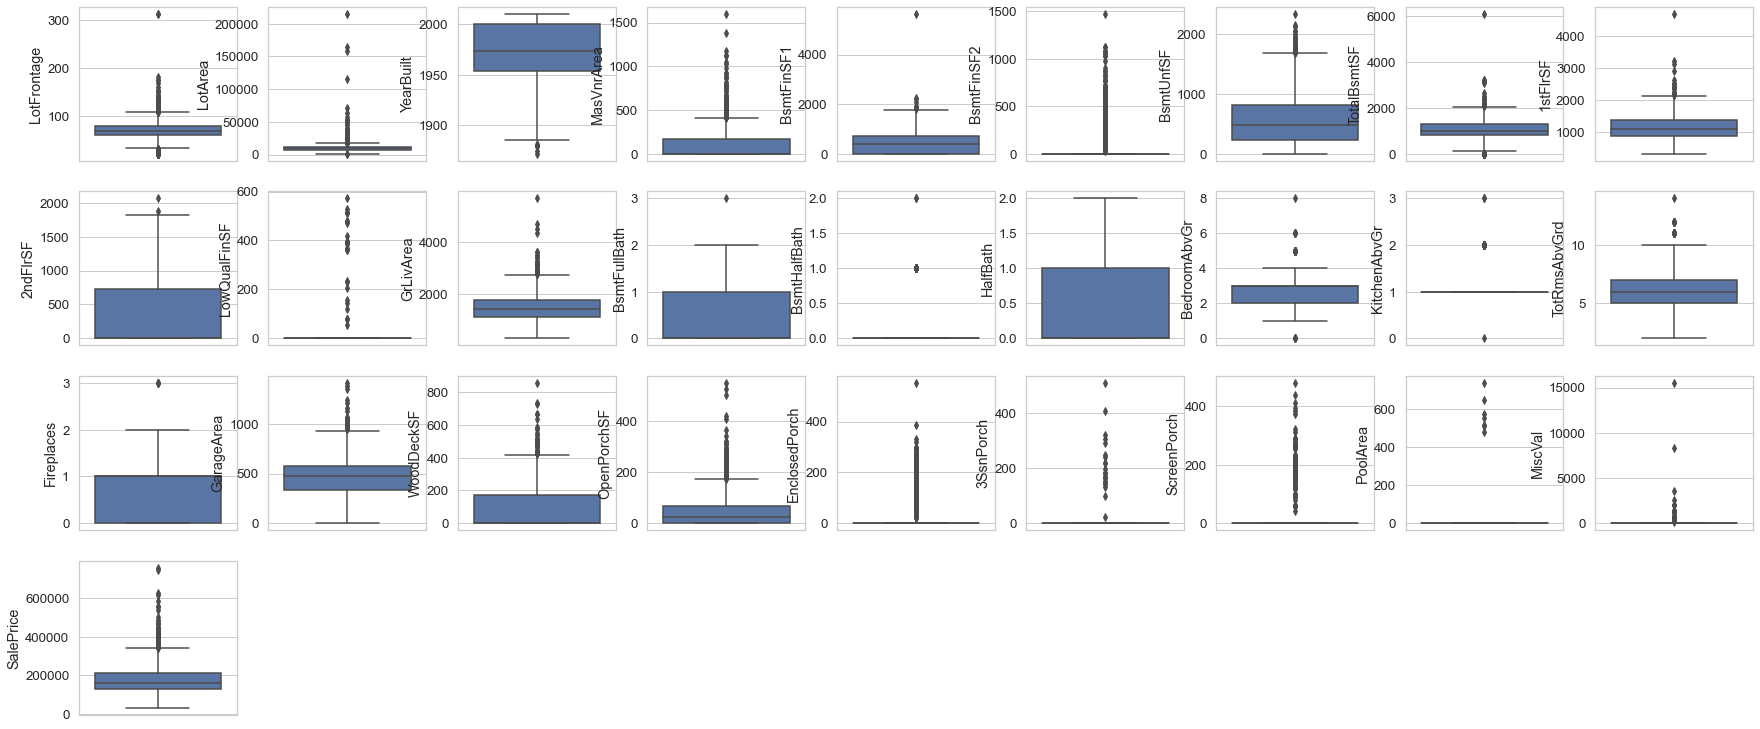

In [33]:
outlier_columns=outlier_info[outlier_info.Outliers>0]["Columns"]
i=int(len(outlier_columns)/3)
plt.figure(figsize=(30,30))
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
j=1
for p,c in enumerate(outlier_columns):
    plt.subplot(i,i,j)
    sns.boxplot(y=price_df[c],orient="h")
    plt.ylabel(c)
    j=j+1
plt.show()

In [34]:
outlier_columns_fix=outlier_info[(outlier_info["Upper Limit"]>20) & (outlier_info.Outliers>0)]["Columns"]
list(outlier_columns_fix)

['LotFrontage',
 'LotArea',
 'YearBuilt',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'SalePrice']

In [35]:
oulier_fix_cols=['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
                 '1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','GarageArea','WoodDeckSF',
                 'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal']
for col in oulier_fix_cols:
    lower_limit=(outlier_info[(outlier_info.Columns==col)]["Lower Limit"].values)[0]
    upper_limit=(outlier_info[(outlier_info.Columns==col)]["Upper Limit"].values)[0]
    price_df[col]=np.where(price_df[col]>upper_limit,upper_limit,price_df[col])
    price_df[col]=np.where(price_df[col]<lower_limit,lower_limit,price_df[col])

In [36]:
price_df[num_list].describe()

LotFrontage              LotArea            YearBuilt  \
count             1,460.00             1,460.00             1,460.00   
mean                 69.44            10,090.56             1,971.27   
std                  19.53             5,223.74                30.20   
min                  21.00             1,300.00             1,872.00   
25%                  60.00             7,553.50             1,954.00   
50%                  69.00             9,478.50             1,973.00   
75%                  79.00            11,601.50             2,000.00   
max                 135.92            40,450.37             2,010.00   

              YearRemodAdd           MasVnrArea           BsmtFinSF1  \
count             1,460.00             1,460.00             1,460.00   
mean              1,984.87                98.36               440.14   
std                  20.65               159.29               433.68   
min               1,950.00                 0.00                 0.00   
25%               1,967.00                 0.00                 0.00   
50%               1,994.00                 0.00               383.50   
75%               2,004.00               164.25               712.25   
max               2,010.00               645.13             1,811.47   

                BsmtFinSF2            BsmtUnfSF          TotalBsmtSF  \
count             1,460.00             1,460.00             1,460.00   
mean                 38.63               566.20             1,052.36   
std                 122.21               438.42               409.56   
min                   0.00                 0.00                 0.00   
25%                   0.00               223.00               795.75   
50%                   0.00               477.50               991.50   
75%                   0.00               808.00             1,298.25   
max                 530.34             1,892.39             2,373.09   

                  1stFlrSF             2ndFlrSF         LowQualFinSF  \
count             1,460.00             1,460.00             1,460.00   
mean              1,158.67               346.36                 2.46   
std                 367.44               434.41                18.67   
min                 334.00                 0.00                 0.00   
25%                 882.00                 0.00                 0.00   
50%               1,087.00                 0.00                 0.00   
75%               1,391.25               728.00                 0.00   
max               2,321.99             1,656.13               151.66   

                 GrLivArea         BsmtFullBath         BsmtHalfBath  \
count             1,460.00             1,460.00             1,460.00   
mean              1,508.87                 0.43                 0.06   
std                 496.03                 0.52                 0.24   
min                 334.00                 0.00                 0.00   
25%               1,129.50                 0.00                 0.00   
50%               1,464.00                 0.00                 0.00   
75%               1,776.75                 1.00                 0.00   
max               3,091.36                 3.00                 2.00   

                  FullBath             HalfBath         BedroomAbvGr  \
count             1,460.00             1,460.00             1,460.00   
mean                  1.57                 0.38                 2.87   
std                   0.55                 0.50                 0.82   
min                   0.00                 0.00                 0.00   
25%                   1.00                 0.00                 2.00   
50%                   2.00                 0.00                 3.00   
75%                   2.00                 1.00                 3.00   
max                   3.00                 2.00                 8.00   

              KitchenAbvGr         TotRmsAbvGrd           Fireplaces  \
count             1,460.00             1,460.00  

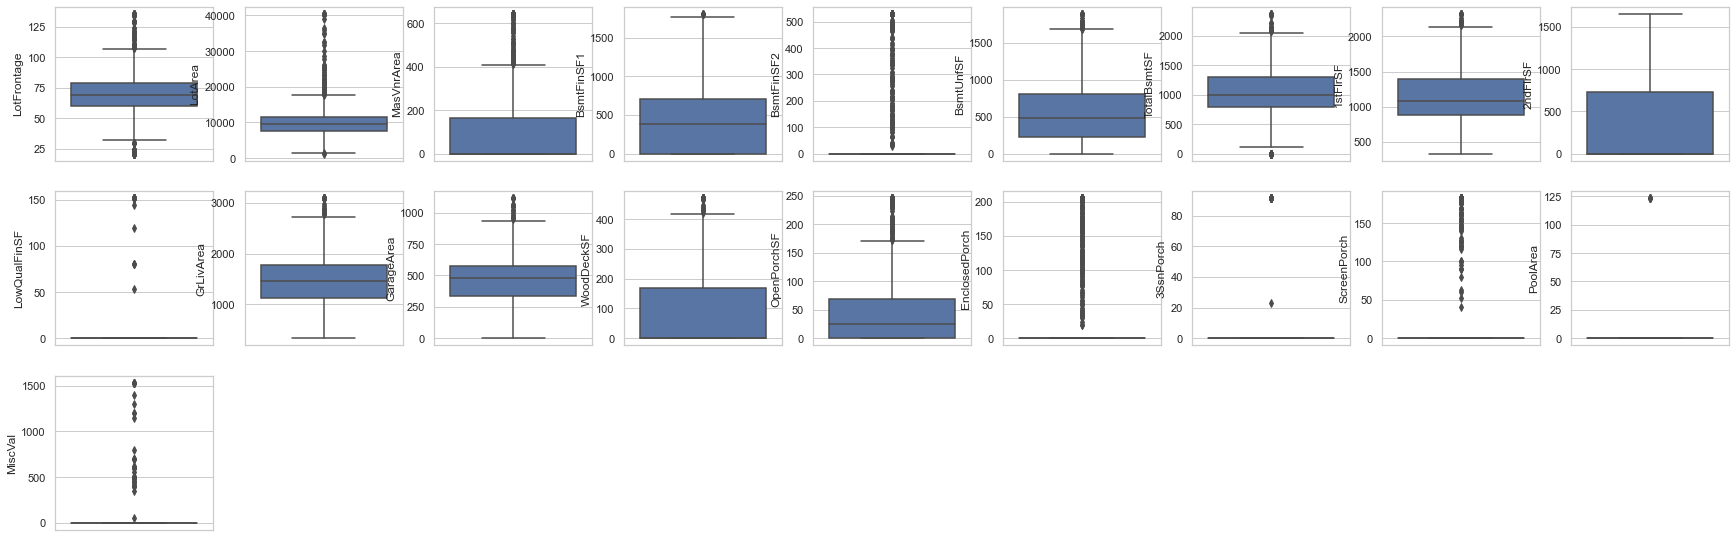

In [37]:
### Post fixing outliers
outlier_columns=outlier_info[outlier_info.Outliers>0]["Columns"]
i=int(len(outlier_columns)/3)
plt.figure(figsize=(30,30))
sns.set(font_scale=1.0)
sns.set_style("whitegrid")
j=1
for p,c in enumerate(oulier_fix_cols):
    plt.subplot(i,i,j)
    sns.boxplot(y=price_df[c],orient="h")
    plt.ylabel(c)
    j=j+1
plt.show()

In [38]:
print("Shape after outlier correction ",price_df.shape ,"rows & columns.")

Shape after outlier correction  (1460, 80) rows & columns.


### H. Feature Engineering(Derived Columns)

In [39]:
price_df.head(5)

MSSubClass MSZoning          LotFrontage              LotArea  \
Id                                                                            
1   2-STORY 1946 & NEWER  RL                     65.00             8,450.00   
2   1-STORY 1946 & NEWER  RL                     80.00             9,600.00   
3   2-STORY 1946 & NEWER  RL                     68.00            11,250.00   
4   2-STORY 1945 & OLDER  RL                     60.00             9,550.00   
5   2-STORY 1946 & NEWER  RL                     84.00            14,260.00   

   Street Alley LotShape LandContour Utilities LotConfig LandSlope  \
Id                                                                   
1   Pave   NA    Reg      Lvl         AllPub    Inside    Gtl        
2   Pave   NA    Reg      Lvl         AllPub    FR2       Gtl        
3   Pave   NA    IR1      Lvl         AllPub    Inside    Gtl        
4   Pave   NA    IR1      Lvl         AllPub    Corner    Gtl        
5   Pave   NA    IR1      Lvl         AllPub    FR2       Gtl        

   Neighborhood Condition1 Condition2 BldgType HouseStyle OverallQual  \
Id                                                                      
1   CollgCr      Norm       Norm       1Fam     2Story     7            
2   Veenker      Feedr      Norm       1Fam     1Story     6            
3   CollgCr      Norm       Norm       1Fam     2Story     7            
4   Crawfor      Norm       Norm       1Fam     2Story     7            
5   NoRidge      Norm       Norm       1Fam     2Story     8            

   OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st  \
Id                                                                       
1   5           2003       2003          Gable     CompShg  VinylSd      
2   8           1976       1976          Gable     CompShg  MetalSd      
3   5           2001       2002          Gable     CompShg  VinylSd      
4   5           1915       1970          Gable     CompShg  Wd Sdng      
5   5           2000       2000          Gable     CompShg  VinylSd      

   Exterior2nd MasVnrType           MasVnrArea ExterQual ExterCond Foundation  \
Id                                                                              
1   VinylSd     BrkFace                 196.00  Gd        TA        PConc       
2   MetalSd     None                      0.00  TA        TA        CBlock      
3   VinylSd     BrkFace                 162.00  Gd        TA        PConc       
4   Wd Shng     None                      0.00  TA        TA        BrkTil      
5   VinylSd     BrkFace                 350.00  Gd        TA        PConc       

   BsmtQual BsmtCond BsmtExposure BsmtFinType1           BsmtFinSF1  \
Id                                                                    
1   Gd       TA       No           GLQ                       706.00   
2   Gd       TA       Gd           ALQ                       978.00   
3   Gd       TA       Mn           GLQ                       486.00   
4   TA       Gd       No           ALQ                       216.00   
5   Gd       TA       Av           GLQ                       655.00   

   BsmtFinType2           BsmtFinSF2            BsmtUnfSF  \
Id                                                          
1   Unf                         0.00               150.00   
2   Unf                         0.00               284.00   
3   Unf                         0.00               434.00   
4   Unf                         0.00               540.00   
5   Unf                         0.00               490.00   

            TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
Id                                                                
1                856.00  GasA    Ex        Y          SBrkr       
2              1,262.00  GasA    Ex        Y          SBrkr       
3                920.00  GasA    Ex        Y          SBrkr       
4                756.00  GasA    Gd        Y          SBrkr       
5              1,145.00  GasA    Ex       

In [40]:
price_df["Age"]=price_df["YrSold"]-price_df["YearBuilt"]
price_df["GarageAge"]=price_df["YrSold"] - price_df["GarageYrBlt"]
price_df["GarageAge"].fillna(99,inplace=True)
price_df["LivLotRatio"] = price_df.GrLivArea / price_df.LotArea
price_df["Spaciousness"] = (price_df["1stFlrSF"] + price_df["2ndFlrSF"]) / price_df.TotRmsAbvGrd
price_df["MedNhbdArea"] = price_df.groupby("Neighborhood")["GrLivArea"].transform("median")
price_df["HouseStyle"]=price_df["HouseStyle"].apply(lambda x: x.replace('Story',''))
price_df["HouseStyle"]=price_df["HouseStyle"].apply(lambda x: x.replace('Fin',''))
price_df["HouseStyle"]=price_df["HouseStyle"].apply(lambda x: x.replace('Unf',''))
price_df["HouseStyle"]=price_df["HouseStyle"].apply(lambda x: x.replace('Lvl',''))
price_df["HouseStyle"]=price_df["HouseStyle"].apply(lambda x: x.replace('Foyer',''))
price_df["HouseStyle"]=price_df["HouseStyle"].apply(lambda x: x.replace('S','1'))
price_df["HouseStyle"]=price_df["HouseStyle"].astype('float64')
MSClass=[k for k,v in zip(list((price_df["MSSubClass"].value_counts()).index),
                          list((price_df["MSSubClass"].value_counts()).values)) if v<70]
Neig=[k for k,v in zip(list((price_df["Neighborhood"].value_counts()).index),
                       list((price_df["Neighborhood"].value_counts()).values)) if v<50]
price_df["MSSubClass"]=price_df["MSSubClass"].apply(lambda x: "Others" if x in MSClass else x)
price_df["Neighborhood"]=price_df["Neighborhood"].apply(lambda x: "Others" if x in Neig else x)
col_to_drop=["YrSold","YearBuilt","GarageYrBlt","YearRemodAdd"]
price_df.drop(col_to_drop,inplace=True,axis=1)
price_df.head()

MSSubClass MSZoning          LotFrontage              LotArea  \
Id                                                                            
1   2-STORY 1946 & NEWER  RL                     65.00             8,450.00   
2   1-STORY 1946 & NEWER  RL                     80.00             9,600.00   
3   2-STORY 1946 & NEWER  RL                     68.00            11,250.00   
4   Others                RL                     60.00             9,550.00   
5   2-STORY 1946 & NEWER  RL                     84.00            14,260.00   

   Street Alley LotShape LandContour Utilities LotConfig LandSlope  \
Id                                                                   
1   Pave   NA    Reg      Lvl         AllPub    Inside    Gtl        
2   Pave   NA    Reg      Lvl         AllPub    FR2       Gtl        
3   Pave   NA    IR1      Lvl         AllPub    Inside    Gtl        
4   Pave   NA    IR1      Lvl         AllPub    Corner    Gtl        
5   Pave   NA    IR1      Lvl         AllPub    FR2       Gtl        

   Neighborhood Condition1 Condition2 BldgType           HouseStyle  \
Id                                                                    
1   CollgCr      Norm       Norm       1Fam                    2.00   
2   Others       Feedr      Norm       1Fam                    1.00   
3   CollgCr      Norm       Norm       1Fam                    2.00   
4   Crawfor      Norm       Norm       1Fam                    2.00   
5   Others       Norm       Norm       1Fam                    2.00   

   OverallQual OverallCond RoofStyle RoofMatl Exterior1st Exterior2nd  \
Id                                                                      
1   7           5           Gable     CompShg  VinylSd     VinylSd      
2   6           8           Gable     CompShg  MetalSd     MetalSd      
3   7           5           Gable     CompShg  VinylSd     VinylSd      
4   7           5           Gable     CompShg  Wd Sdng     Wd Shng      
5   8           5           Gable     CompShg  VinylSd     VinylSd      

   MasVnrType           MasVnrArea ExterQual ExterCond Foundation BsmtQual  \
Id                                                                           
1   BrkFace                 196.00  Gd        TA        PConc      Gd        
2   None                      0.00  TA        TA        CBlock     Gd        
3   BrkFace                 162.00  Gd        TA        PConc      Gd        
4   None                      0.00  TA        TA        BrkTil     TA        
5   BrkFace                 350.00  Gd        TA        PConc      Gd        

   BsmtCond BsmtExposure BsmtFinType1           BsmtFinSF1 BsmtFinType2  \
Id                                                                        
1   TA       No           GLQ                       706.00  Unf           
2   TA       Gd           ALQ                       978.00  Unf           
3   TA       Mn           GLQ                       486.00  Unf           
4   Gd       No           ALQ                       216.00  Unf           
5   TA       Av           GLQ                       655.00  Unf           

             BsmtFinSF2            BsmtUnfSF          TotalBsmtSF Heating  \
Id                                                                          
1                  0.00               150.00               856.00  GasA     
2                  0.00               284.00             1,262.00  GasA     
3                  0.00               434.00               920.00  GasA     
4                  0.00               540.00               756.00  GasA     
5                  0.00               490.00             1,145.00  GasA     

   HeatingQC CentralAir Electrical             1stFlrSF             2ndFlrSF  \
Id                                                                             
1   Ex        Y          SBrkr                   856.00               854.00   
2   Ex        Y          SBrkr                 1,262.00                 0.00   
3   Ex        Y          S

In [41]:
print("Shape after dervived columns ",price_df.shape ,"rows & columns.")

Shape after dervived columns  (1460, 81) rows & columns.


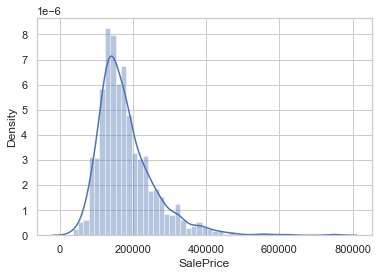

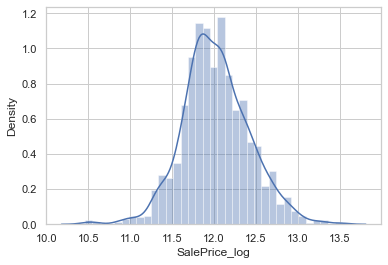

In [42]:
x = price_df["SalePrice"]
sns.set_style("whitegrid")
sns.distplot(x)
plt.show()

price_df["SalePrice_log"] = np.log(price_df.SalePrice)
x = price_df.SalePrice_log
sns.distplot(x)
plt.show()

**Analysis** - As SalesPrice has Skewed Data, we are doing log conversion of it

### Step 2: Data Visualisation

In [43]:
cat_list,num_list=col_list(price_df)
print("Category Columns:",cat_list)
print("Continous Columns:",num_list)
display(len(cat_list),len(num_list))

Category Columns: ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition']
Continous Columns: ['LotFrontage', 'LotArea', 'HouseStyle', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'Enc

46

36

#### Visualising Continous Columns

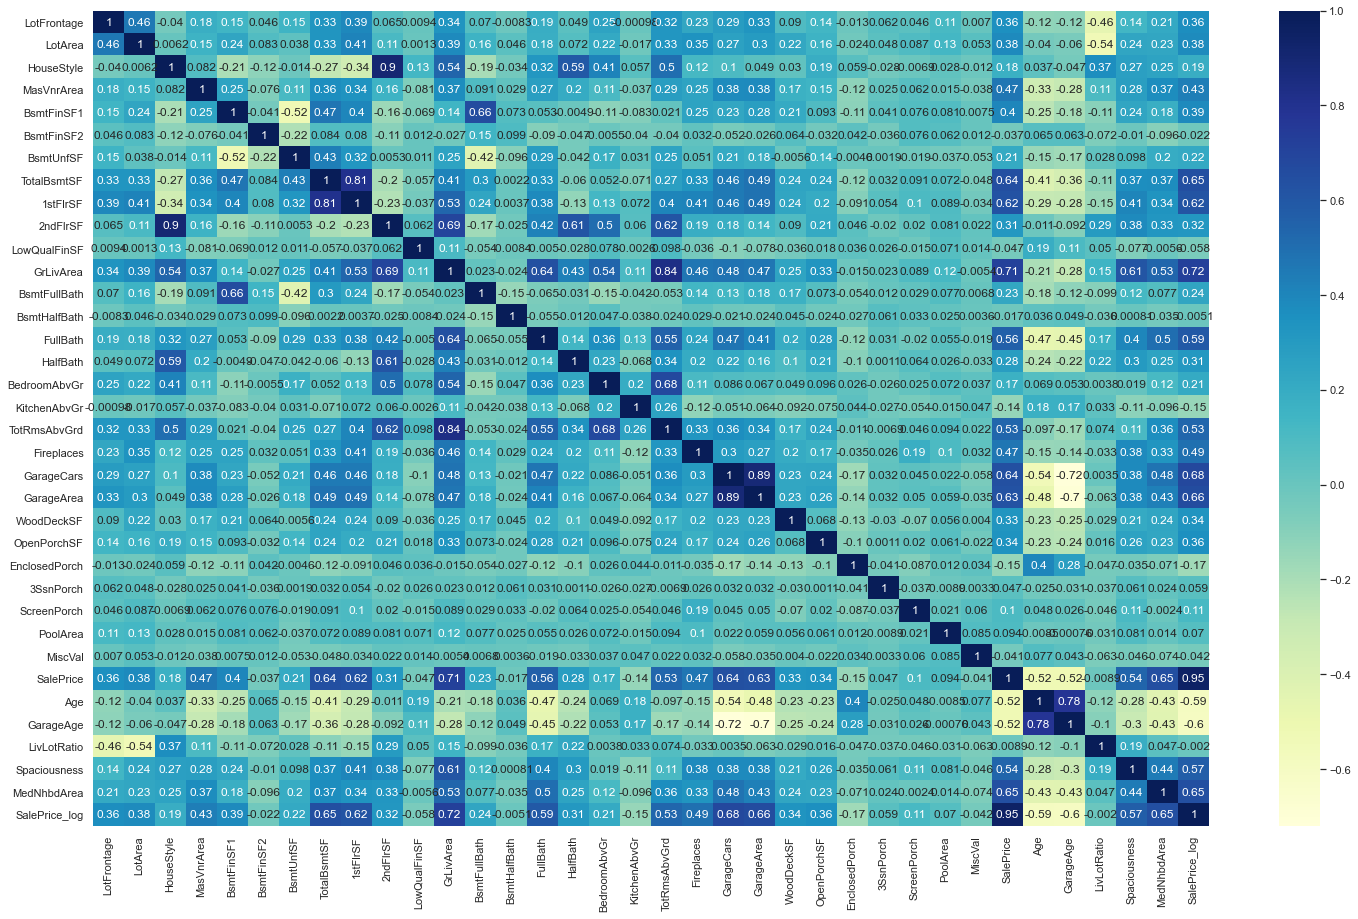

In [44]:
plt.figure(figsize = (25, 15))
sns.heatmap(price_df[num_list].corr(), annot = True, cmap="YlGnBu")
plt.show()

<font color='green'/>**Analysis** - Following Columns have high correlation:
1. LotFrontage with LotArea
2. Sales Price with Total SF, FullBath, TotRmsAbvGrd,Fireplaces,GarageCars,GrLivingArea,TotalBasementSF
3. Living Area with FillPath,BeadroomAbrGr,TotRmsAbvGround,Fireplaces,GarageCars
4. Timeduration of house has negaative correlation with sales price,garagecars,fullpath


Thus, while building the model, we'll have to pay attention to multicollinearity

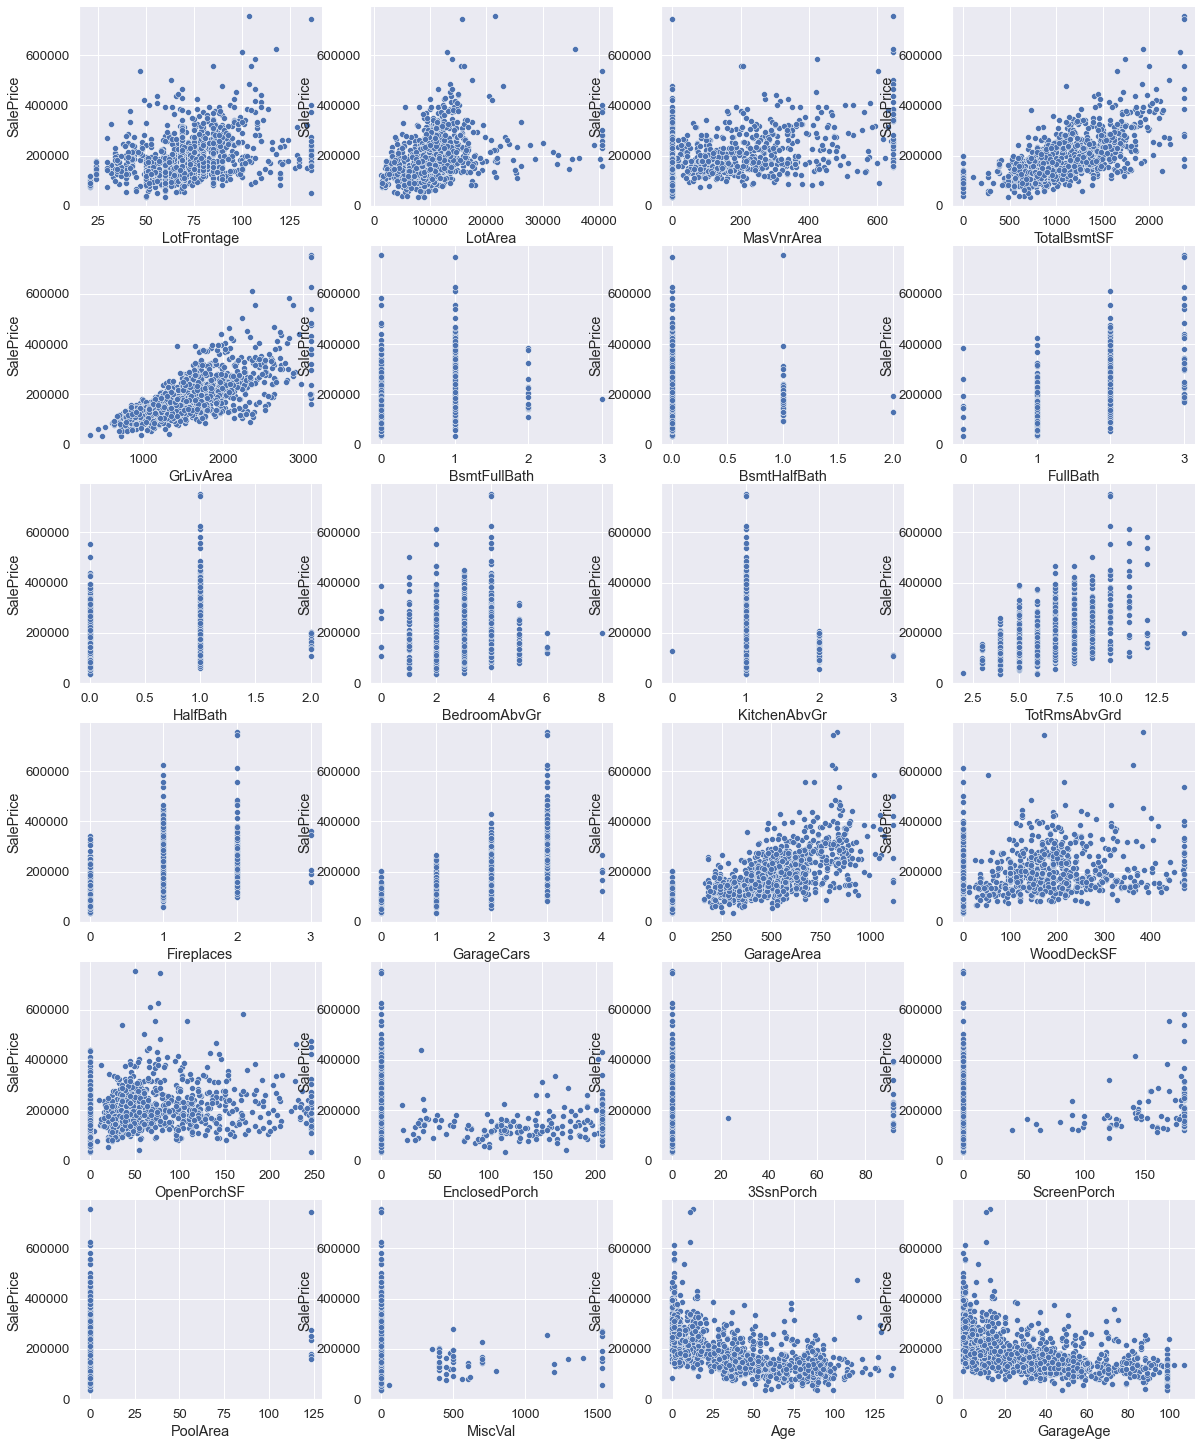

In [45]:
Quality_features = ['LotFrontage', 'LotArea', 'MasVnrArea', 'TotalBsmtSF', 'GrLivArea',
                    'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
                    'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
                    'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal','Age','GarageAge']
plt.figure(figsize=(20, 30))
sns.set(font_scale= 1.2)
sns.set_style('darkgrid')

for i, feature in enumerate(Quality_features):
    plt.subplot(7, 4, i+1)
    sns.scatterplot(data=price_df, x=feature, y='SalePrice', palette="ch:.10")         
sns.despine()

<Figure size 720x720 with 0 Axes>

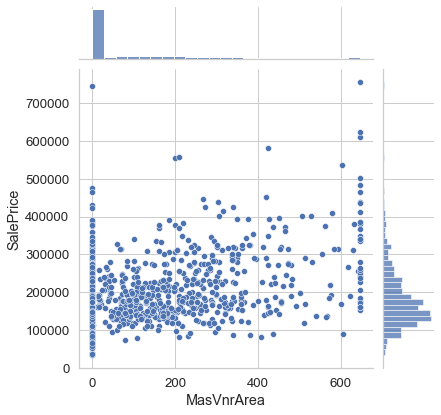

<Figure size 720x720 with 0 Axes>

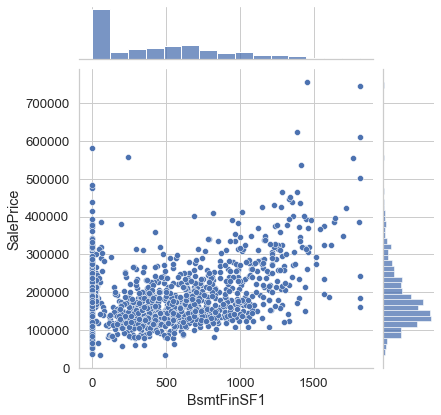

<Figure size 720x720 with 0 Axes>

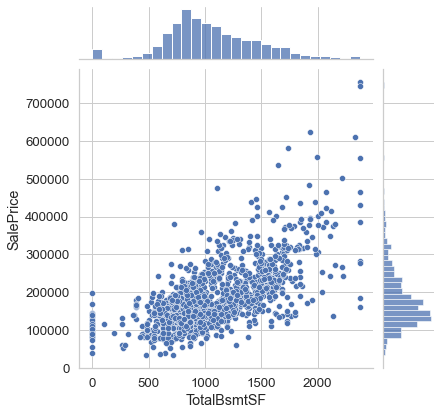

<Figure size 720x720 with 0 Axes>

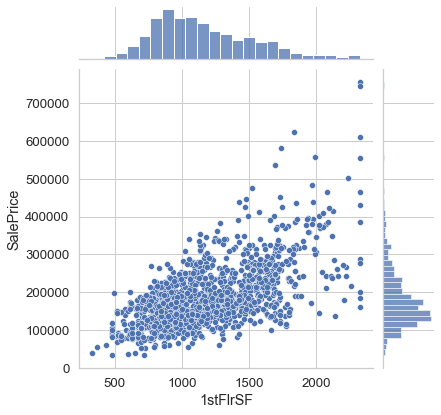

<Figure size 720x720 with 0 Axes>

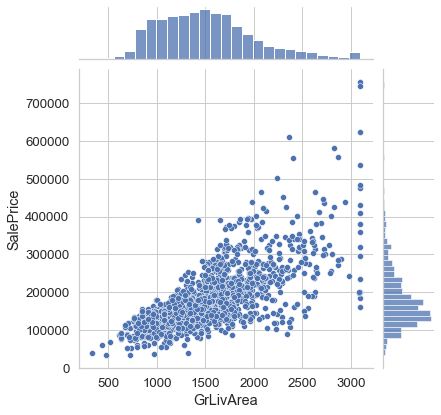

<Figure size 720x720 with 0 Axes>

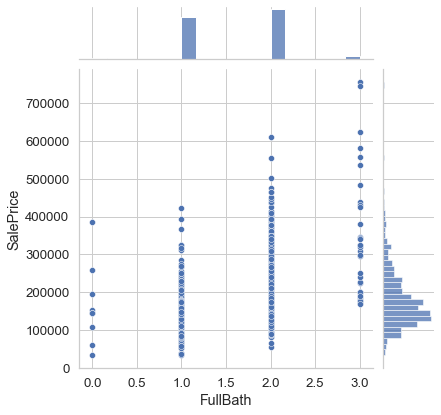

<Figure size 720x720 with 0 Axes>

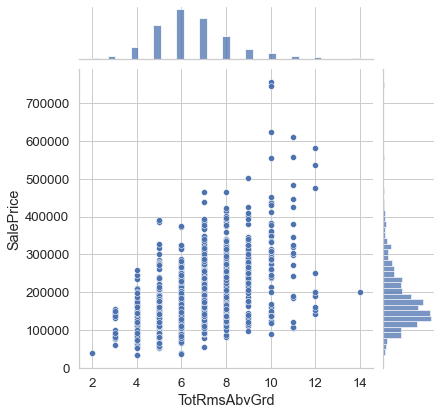

<Figure size 720x720 with 0 Axes>

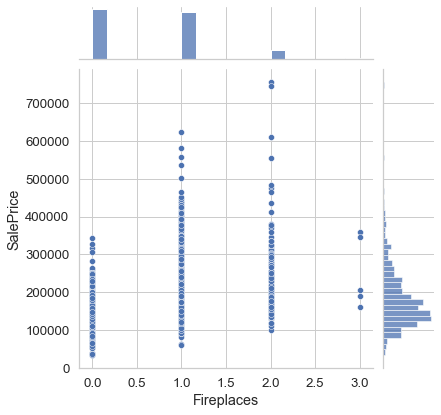

<Figure size 720x720 with 0 Axes>

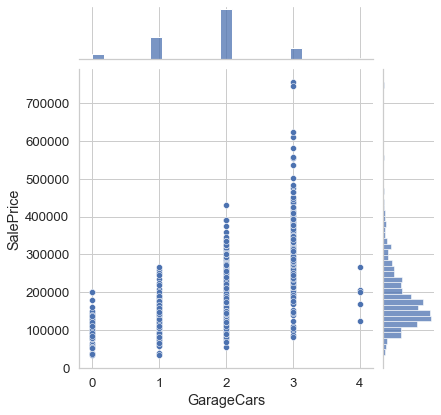

<Figure size 720x720 with 0 Axes>

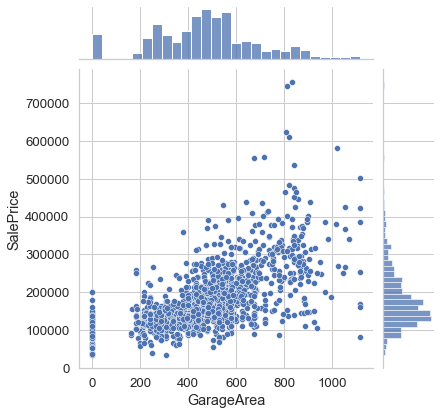

<Figure size 720x720 with 0 Axes>

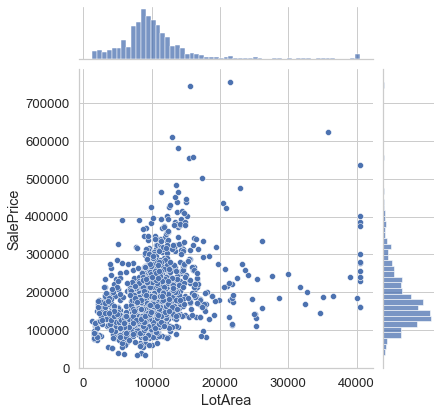

<Figure size 720x720 with 0 Axes>

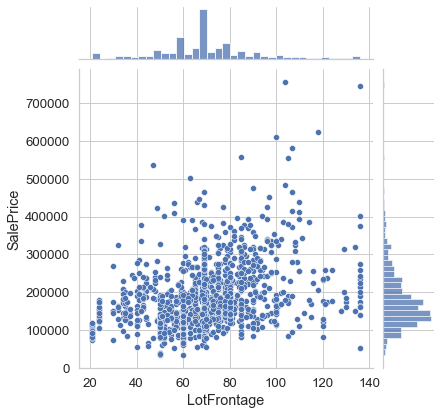

In [46]:
# We will plot some joint histogram and scatter grphs to look at correlated features in more detail
y = price_df["SalePrice"]
features = [
    "MasVnrArea",
    "BsmtFinSF1",
    "TotalBsmtSF",
    "1stFlrSF",
    "GrLivArea",
    "FullBath",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageCars",
    "GarageArea",
    "LotArea",
    "LotFrontage",
]

for features in features:
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 10))
    x = price_df[features]
    sns.jointplot(x=x, y=y, data=price_df)

#### Visualising Categorical Columns

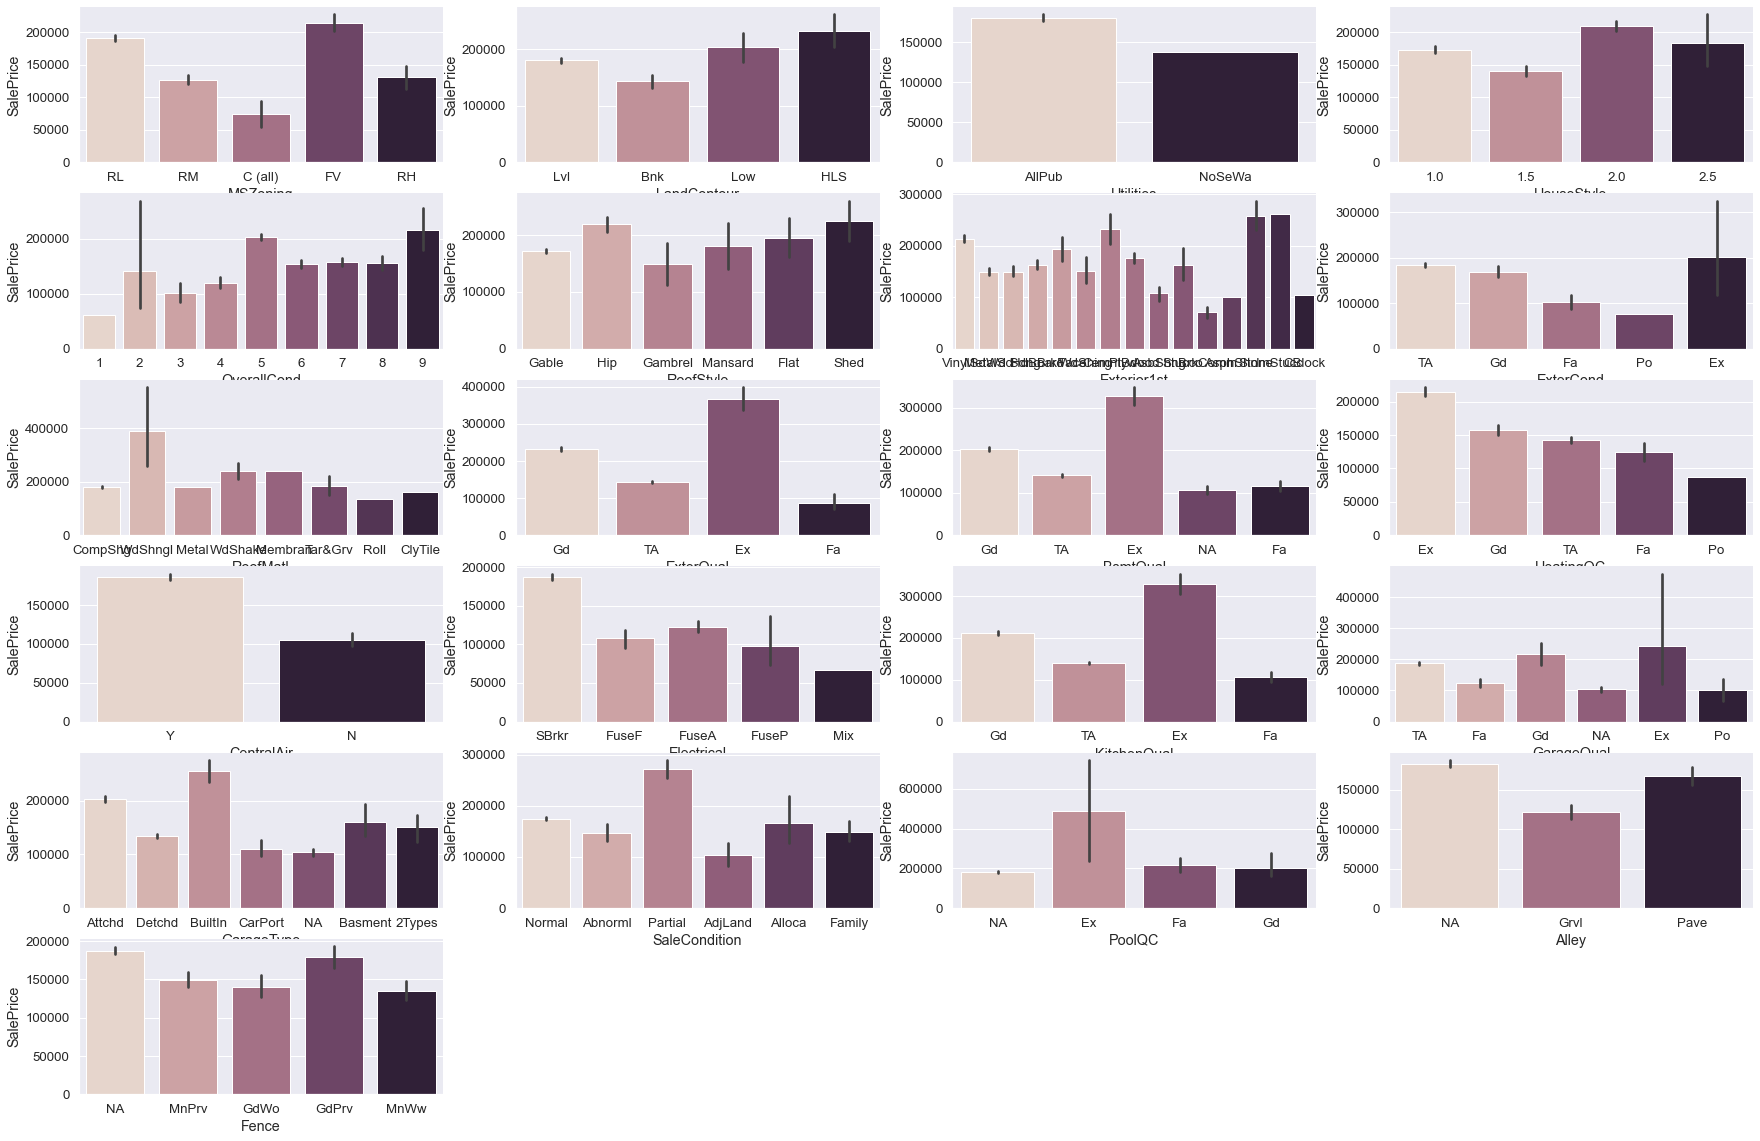

In [47]:
Quality_features = ['MSZoning','LandContour','Utilities','HouseStyle','OverallCond','RoofStyle','Exterior1st','ExterCond',
                    'RoofMatl', 'ExterQual', 'BsmtQual', 'HeatingQC', 'CentralAir', 
                    'Electrical', 'KitchenQual', 'GarageQual','GarageType','SaleCondition','PoolQC','Alley','Fence']

plt.figure(figsize=(30, 20))
sns.set(font_scale= 1.2)
sns.set_style('darkgrid')

for i, feature in enumerate(Quality_features):
    plt.subplot(6, 4, i+1)
    sns.barplot(data=price_df, x=feature, y='SalePrice', palette="ch:.10")         
sns.despine()

<Figure size 2160x1440 with 0 Axes>

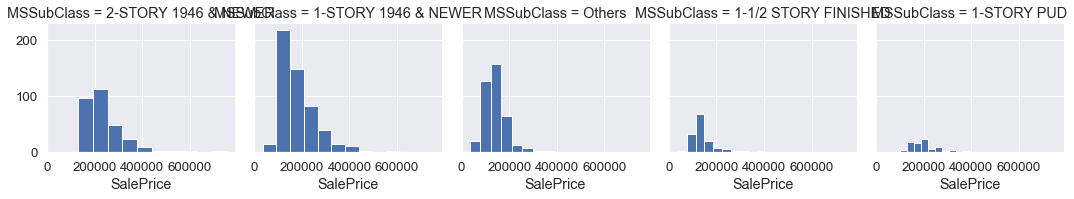

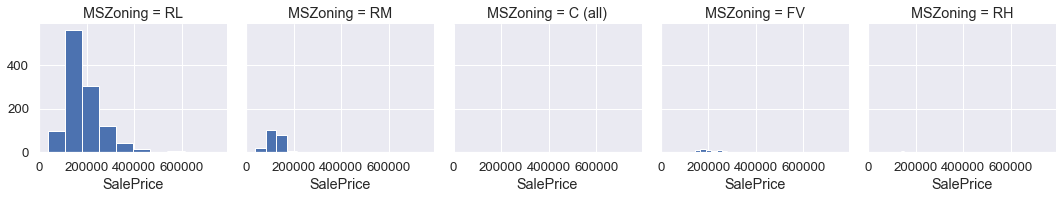

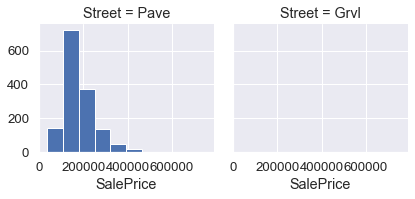

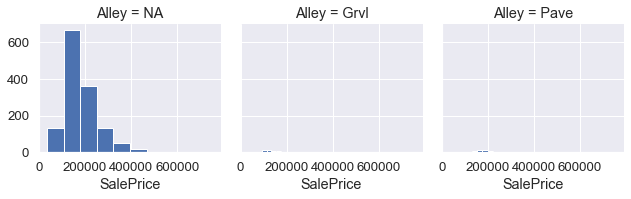

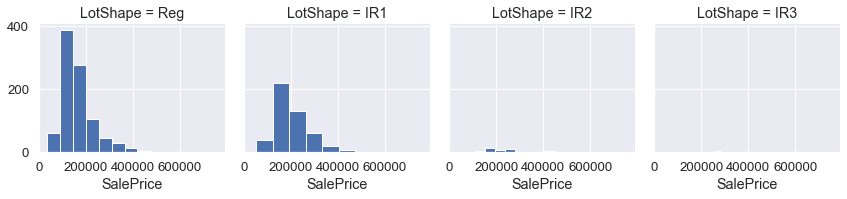

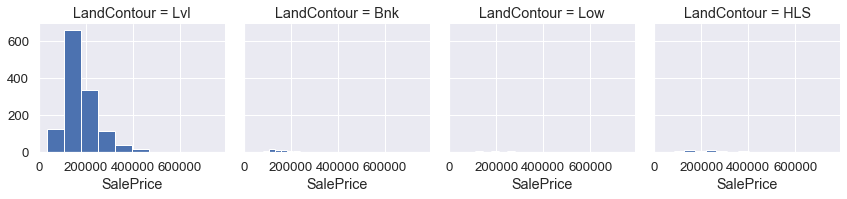

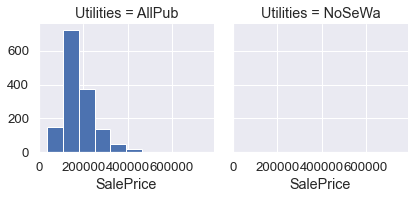

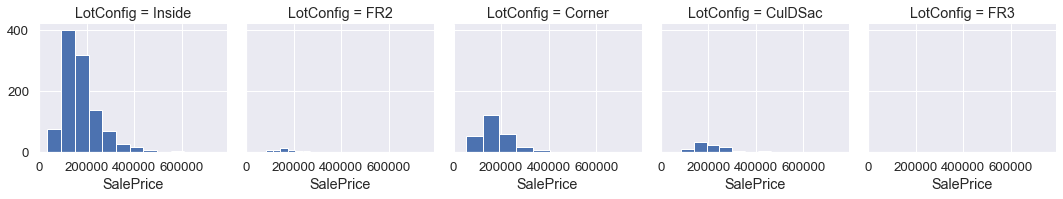

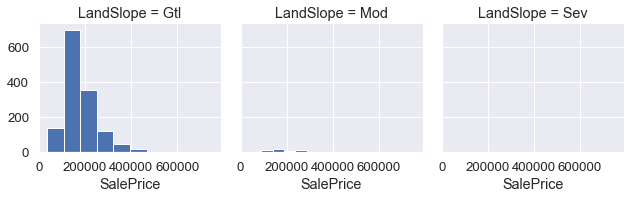

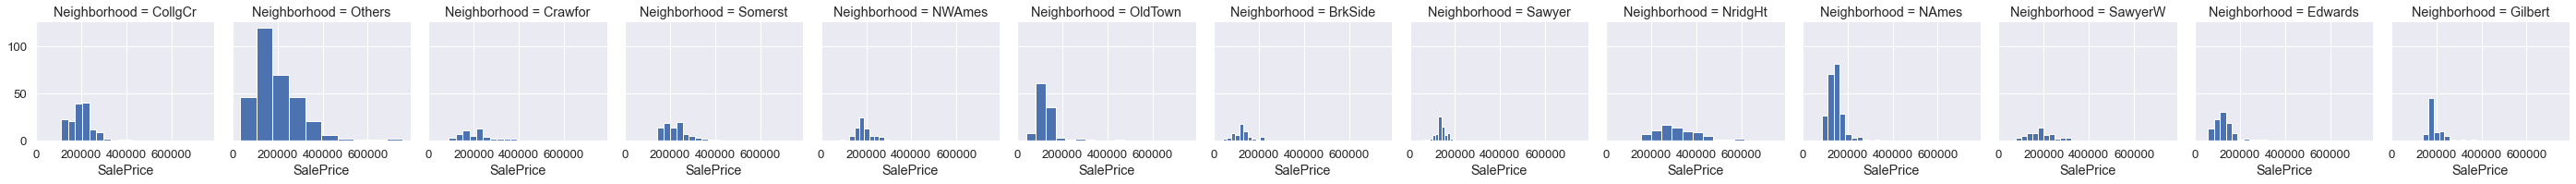

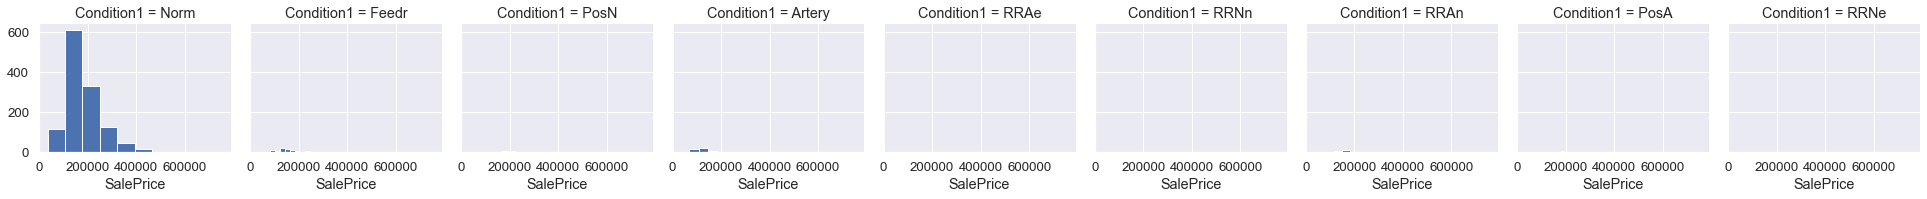

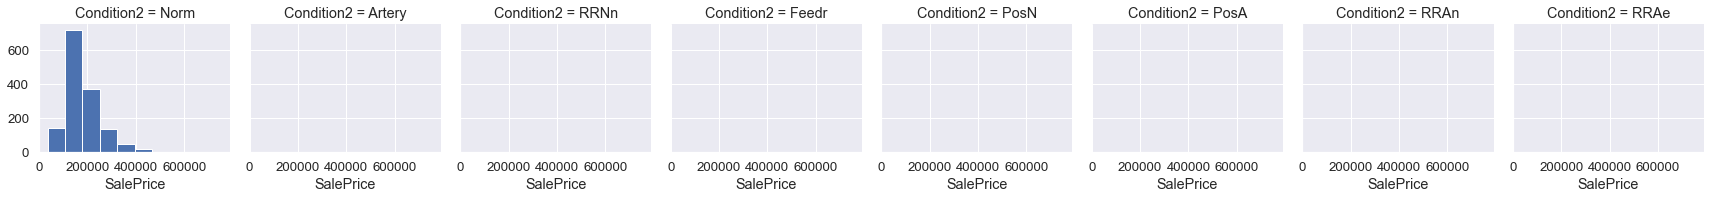

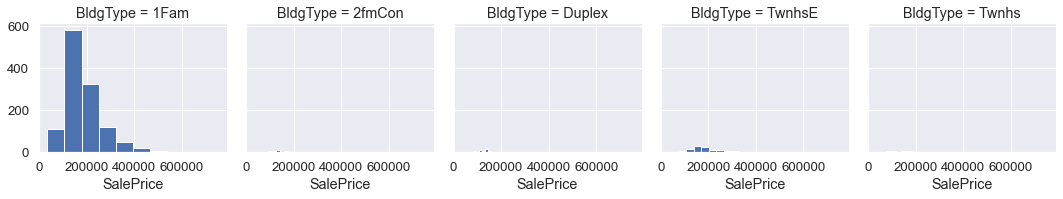

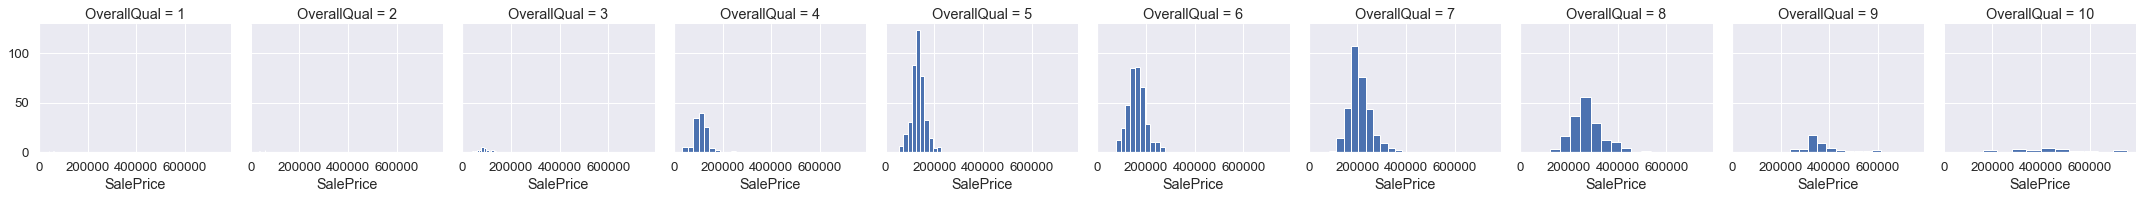

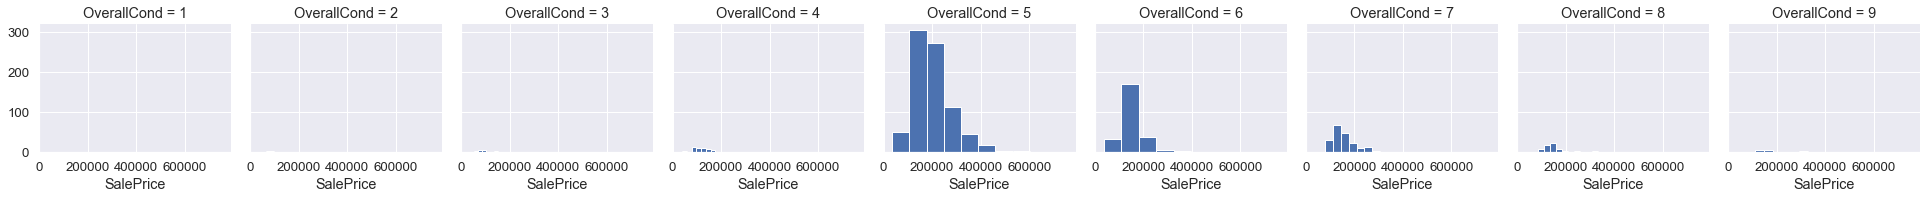

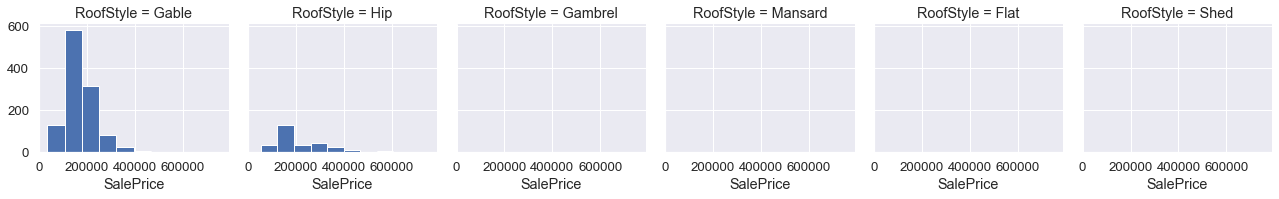

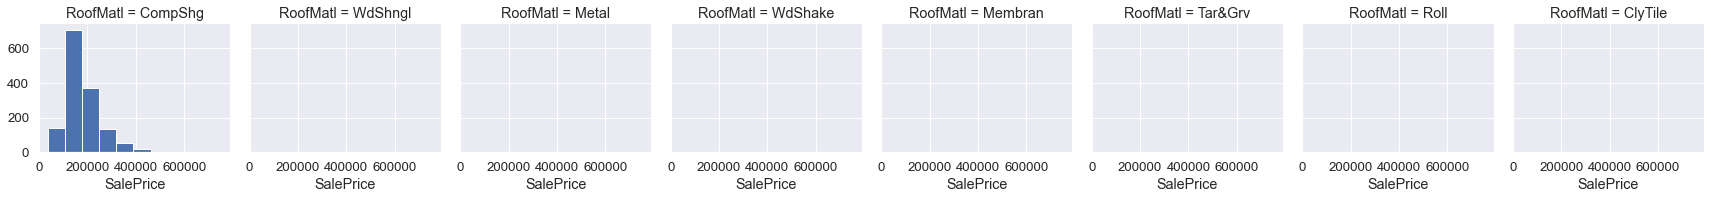

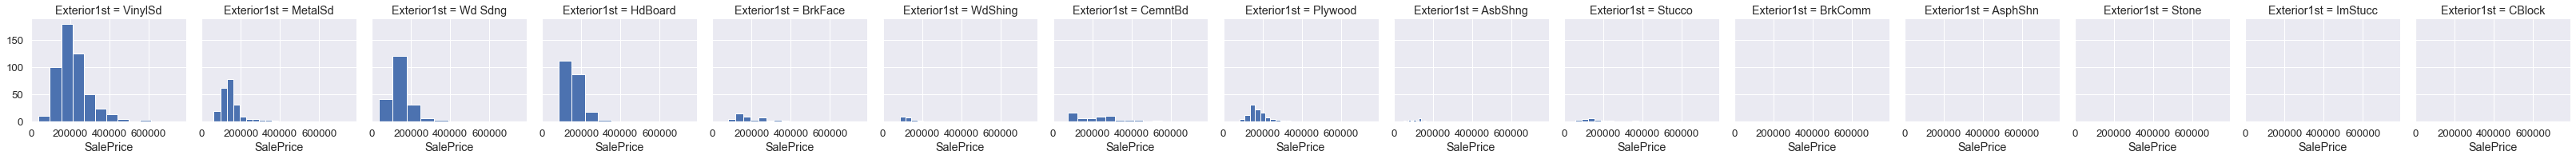

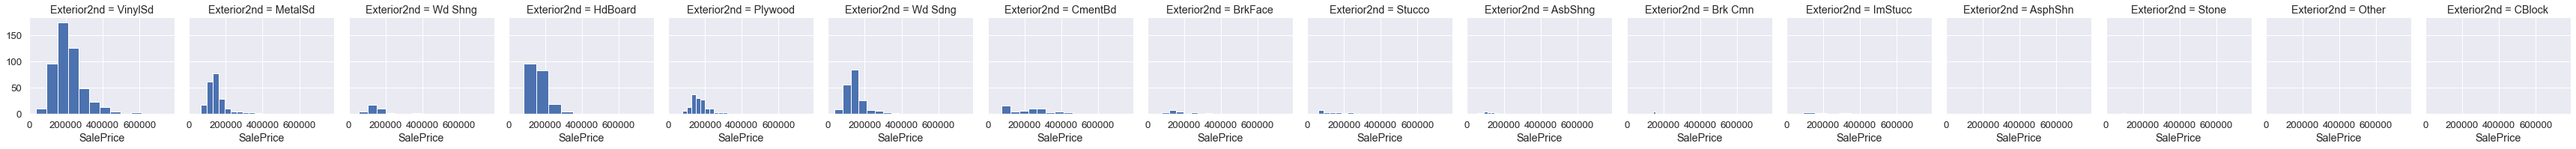

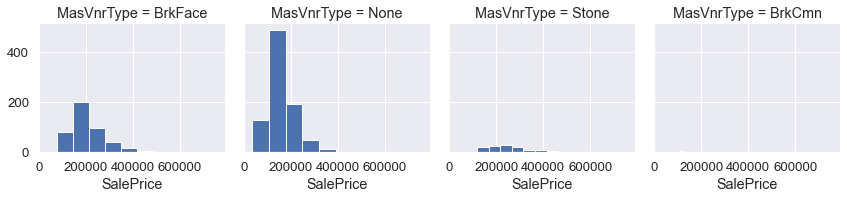

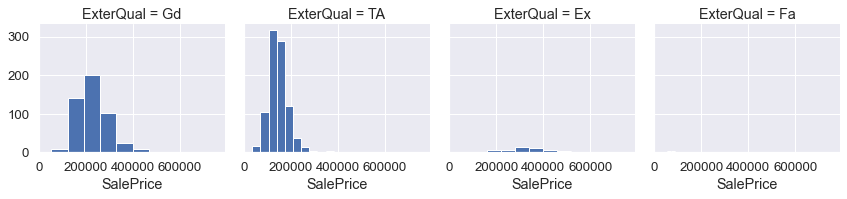

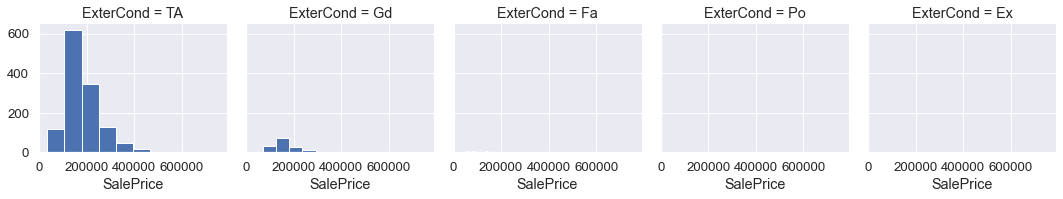

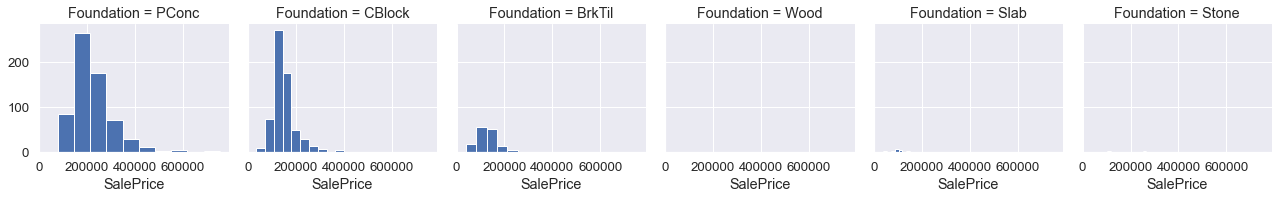

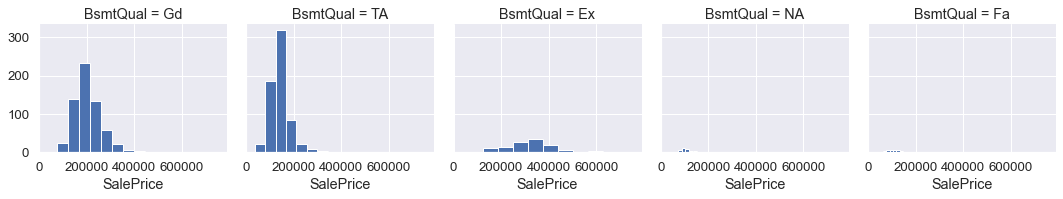

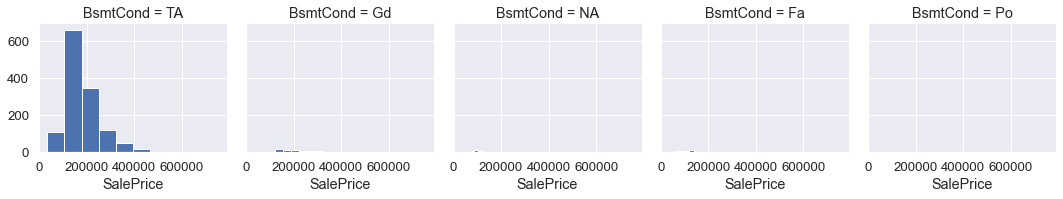

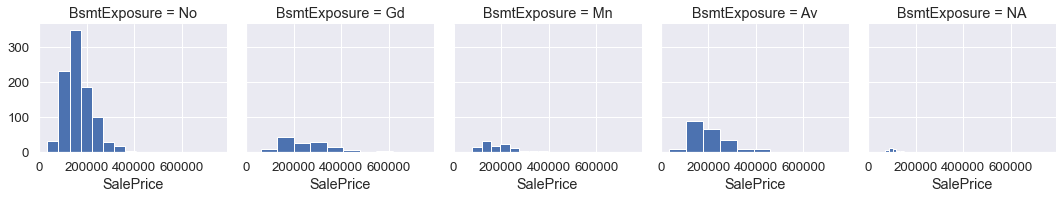

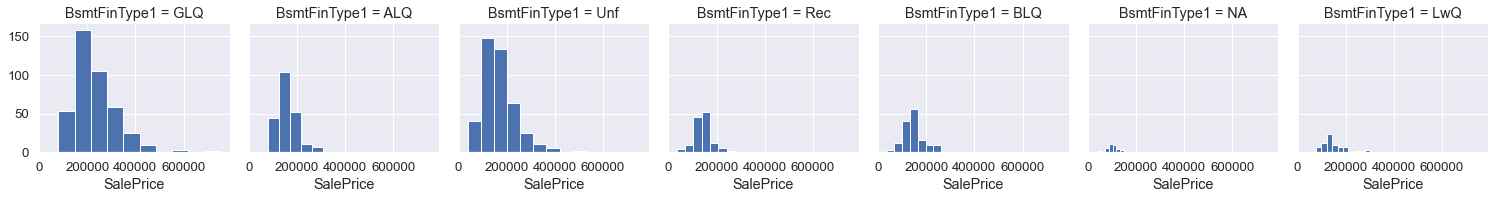

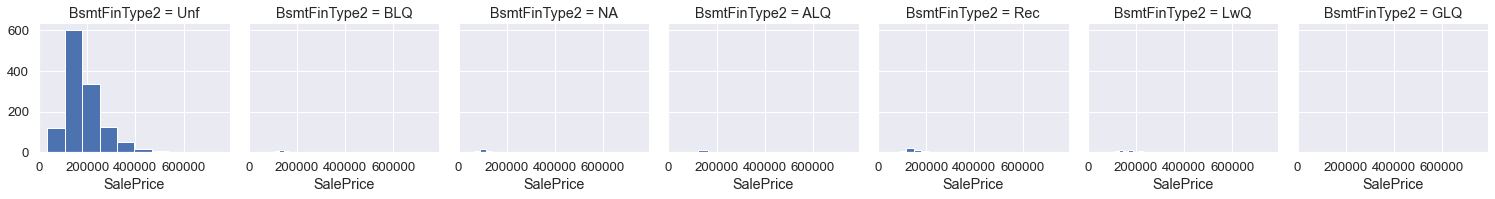

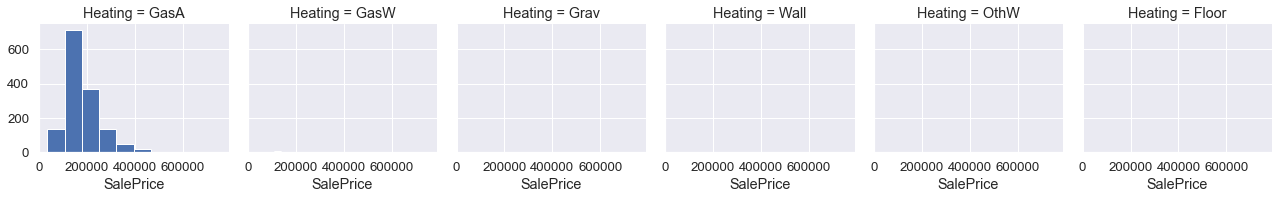

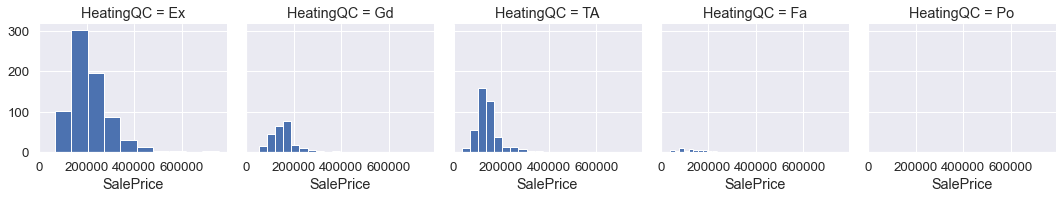

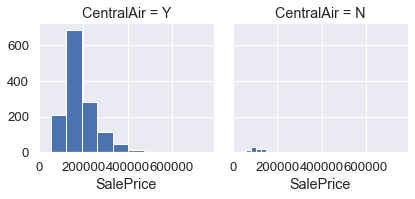

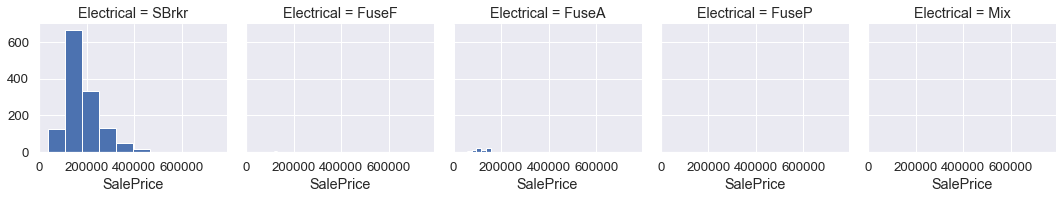

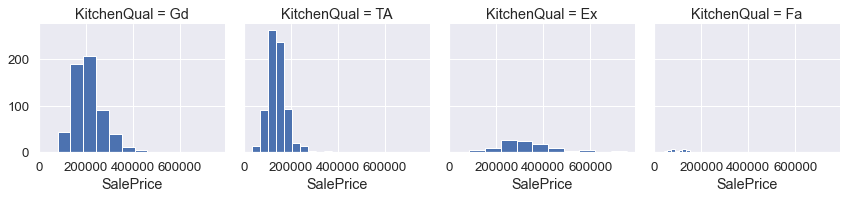

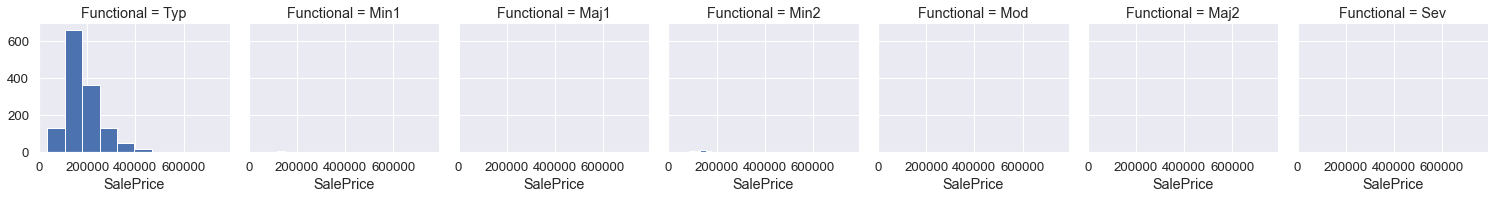

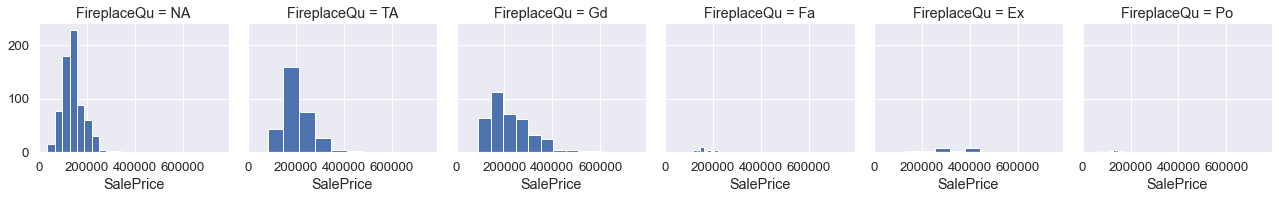

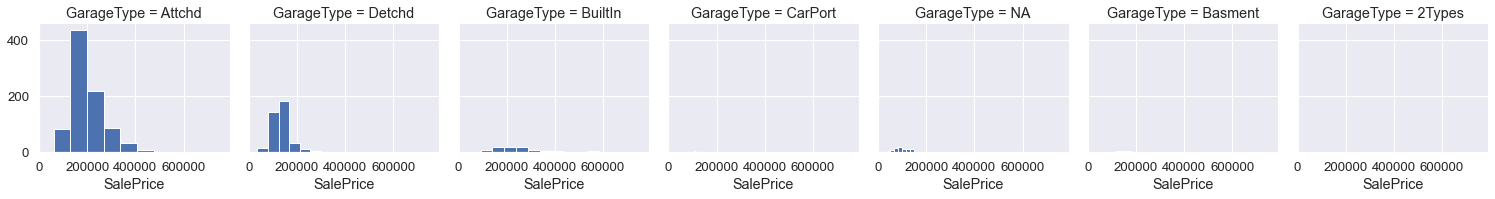

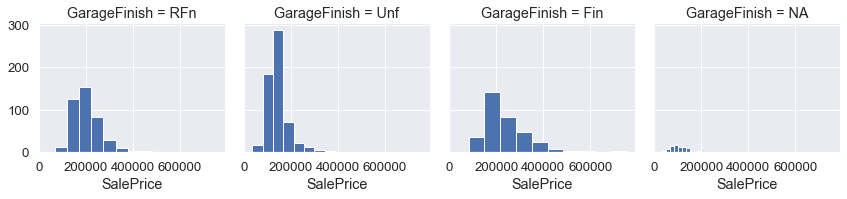

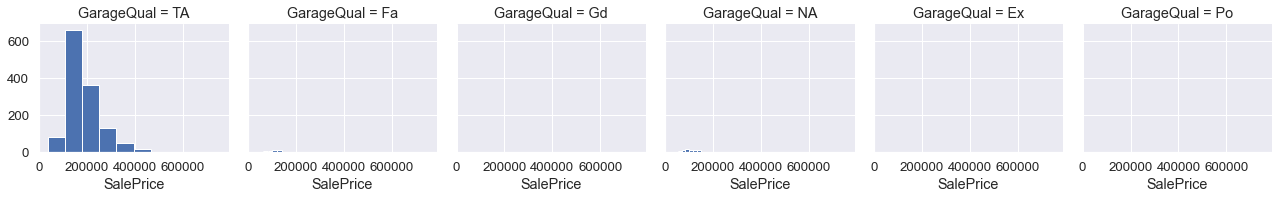

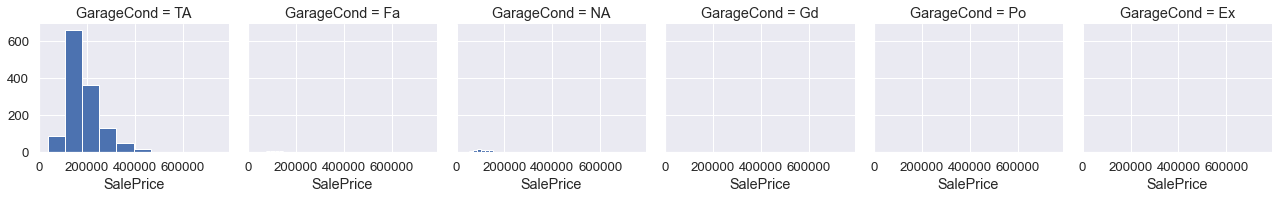

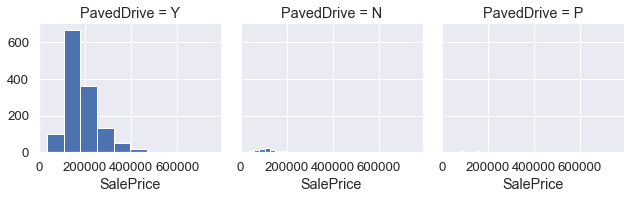

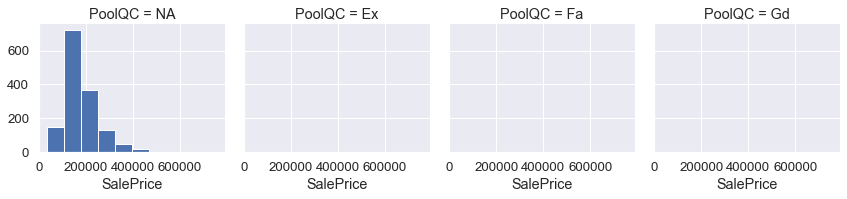

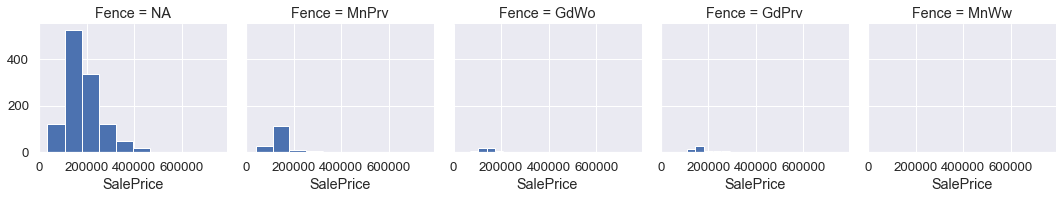

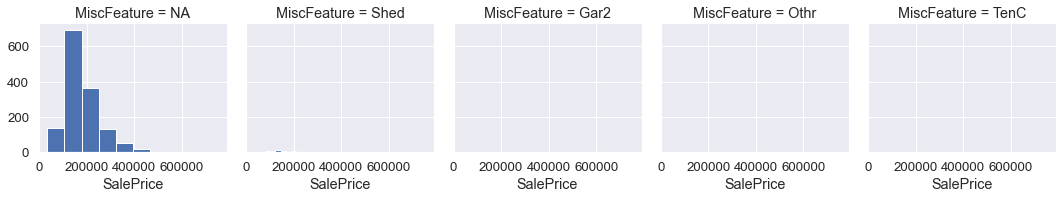

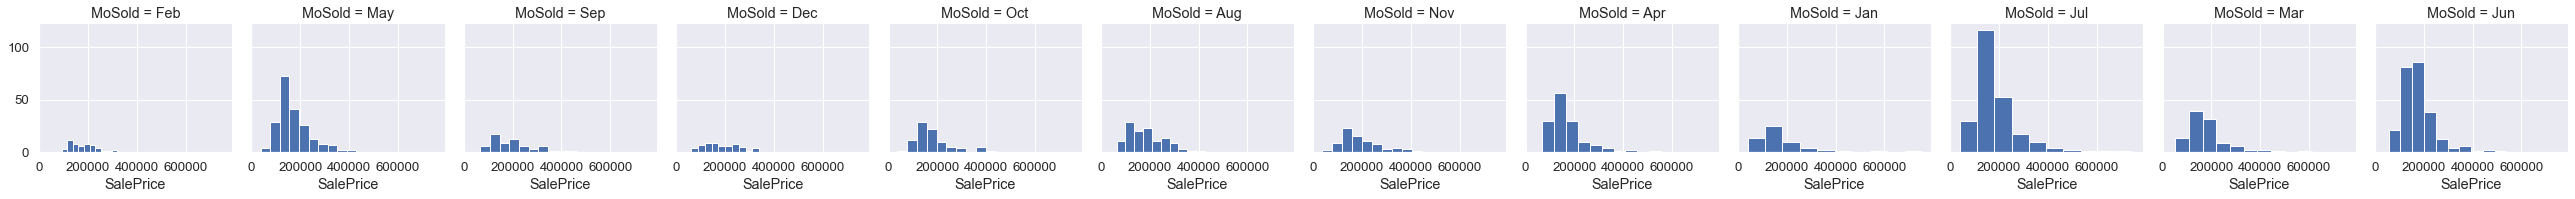

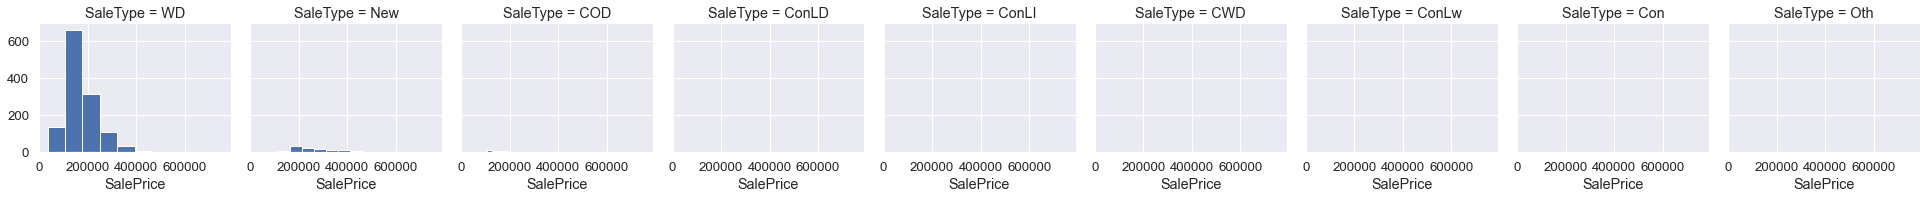

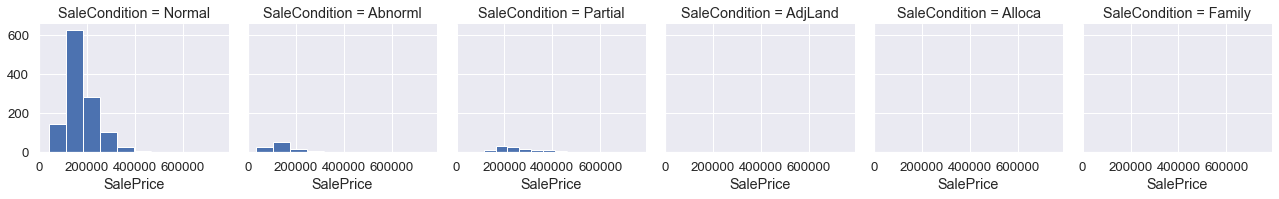

In [48]:
features = price_df.select_dtypes(include=['object']).columns
plt.figure(figsize=(30, 20))
sns.set_style('darkgrid')

for feature in features:
    g = sns.FacetGrid(price_df, col=feature)
    g.map(plt.hist, 'SalePrice');
    sns.despine()

**Analysis** - Lots of categorical columns have data skewed to one/two category like:
'MSZoning','Street','Alley','LandContour','Utilities','LandSlope',
'Condition1','Condition2','BldgType','RoofStyle','RoofMatl','ExterCond','BsmtCond',
'BsmtFinType2','Heating','CentralAir','Electrical','Functional',
'GarageQual','GarageCond','PavedDrive','PoolQC','Fence','MiscFeature','SaleType','SaleCondition'
and needs to binned properly

In [49]:

binn_col=['MSZoning','Street','Alley','LandContour',
'Condition1','Condition2','BldgType','RoofStyle','RoofMatl','Heating','CentralAir','Electrical',
'PavedDrive','Fence','MiscFeature','SaleType','SaleCondition']
x=dict()
x["MSZoning"]=300
x["Street"]=10
x["Alley"]=60
x["LandContour"]=70
x["LandSlope"]=70
x["Condition1"]=100
x["Condition2"]=10
x["BldgType"]=120
x["RoofStyle"]=300
x["RoofMatl"]=15
x["Heating"]=20
x['Electrical']=100
x['Functional']=40
x['PavedDrive']=100
x['Fence']=160
x['MiscFeature']=50
x['SaleType']=130
x['SaleCondition']=130
for p,y in x.items():
    val=[k for k,v in zip(list((price_df[p].value_counts()).index),
                       list((price_df[p].value_counts()).values)) if v<y]
    price_df[p]=price_df[p].apply(lambda x: "Others" if x in val else x)
price_df.head()


MSSubClass MSZoning          LotFrontage              LotArea  \
Id                                                                            
1   2-STORY 1946 & NEWER  RL                     65.00             8,450.00   
2   1-STORY 1946 & NEWER  RL                     80.00             9,600.00   
3   2-STORY 1946 & NEWER  RL                     68.00            11,250.00   
4   Others                RL                     60.00             9,550.00   
5   2-STORY 1946 & NEWER  RL                     84.00            14,260.00   

   Street Alley LotShape LandContour Utilities LotConfig LandSlope  \
Id                                                                   
1   Pave   NA    Reg      Lvl         AllPub    Inside    Gtl        
2   Pave   NA    Reg      Lvl         AllPub    FR2       Gtl        
3   Pave   NA    IR1      Lvl         AllPub    Inside    Gtl        
4   Pave   NA    IR1      Lvl         AllPub    Corner    Gtl        
5   Pave   NA    IR1      Lvl         AllPub    FR2       Gtl        

   Neighborhood Condition1 Condition2 BldgType           HouseStyle  \
Id                                                                    
1   CollgCr      Norm       Norm       1Fam                    2.00   
2   Others       Others     Norm       1Fam                    1.00   
3   CollgCr      Norm       Norm       1Fam                    2.00   
4   Crawfor      Norm       Norm       1Fam                    2.00   
5   Others       Norm       Norm       1Fam                    2.00   

   OverallQual OverallCond RoofStyle RoofMatl Exterior1st Exterior2nd  \
Id                                                                      
1   7           5           Gable     CompShg  VinylSd     VinylSd      
2   6           8           Gable     CompShg  MetalSd     MetalSd      
3   7           5           Gable     CompShg  VinylSd     VinylSd      
4   7           5           Gable     CompShg  Wd Sdng     Wd Shng      
5   8           5           Gable     CompShg  VinylSd     VinylSd      

   MasVnrType           MasVnrArea ExterQual ExterCond Foundation BsmtQual  \
Id                                                                           
1   BrkFace                 196.00  Gd        TA        PConc      Gd        
2   None                      0.00  TA        TA        CBlock     Gd        
3   BrkFace                 162.00  Gd        TA        PConc      Gd        
4   None                      0.00  TA        TA        BrkTil     TA        
5   BrkFace                 350.00  Gd        TA        PConc      Gd        

   BsmtCond BsmtExposure BsmtFinType1           BsmtFinSF1 BsmtFinType2  \
Id                                                                        
1   TA       No           GLQ                       706.00  Unf           
2   TA       Gd           ALQ                       978.00  Unf           
3   TA       Mn           GLQ                       486.00  Unf           
4   Gd       No           ALQ                       216.00  Unf           
5   TA       Av           GLQ                       655.00  Unf           

             BsmtFinSF2            BsmtUnfSF          TotalBsmtSF Heating  \
Id                                                                          
1                  0.00               150.00               856.00  GasA     
2                  0.00               284.00             1,262.00  GasA     
3                  0.00               434.00               920.00  GasA     
4                  0.00               540.00               756.00  GasA     
5                  0.00               490.00             1,145.00  GasA     

   HeatingQC CentralAir Electrical             1stFlrSF             2ndFlrSF  \
Id                                                                             
1   Ex        Y          SBrkr                   856.00               854.00   
2   Ex        Y          SBrkr                 1,262.00                 0.00   
3   Ex        Y          S

### Step 3: Data Preparation

In [50]:
bkp=price_df

In [51]:
price_df=bkp
#price_df=price_df.drop(col_to_drop,axis=1)
display(price_df.dtypes.value_counts())
price_df.head()

object     46
float64    25
int64      11
dtype: int64

MSSubClass MSZoning          LotFrontage              LotArea  \
Id                                                                            
1   2-STORY 1946 & NEWER  RL                     65.00             8,450.00   
2   1-STORY 1946 & NEWER  RL                     80.00             9,600.00   
3   2-STORY 1946 & NEWER  RL                     68.00            11,250.00   
4   Others                RL                     60.00             9,550.00   
5   2-STORY 1946 & NEWER  RL                     84.00            14,260.00   

   Street Alley LotShape LandContour Utilities LotConfig LandSlope  \
Id                                                                   
1   Pave   NA    Reg      Lvl         AllPub    Inside    Gtl        
2   Pave   NA    Reg      Lvl         AllPub    FR2       Gtl        
3   Pave   NA    IR1      Lvl         AllPub    Inside    Gtl        
4   Pave   NA    IR1      Lvl         AllPub    Corner    Gtl        
5   Pave   NA    IR1      Lvl         AllPub    FR2       Gtl        

   Neighborhood Condition1 Condition2 BldgType           HouseStyle  \
Id                                                                    
1   CollgCr      Norm       Norm       1Fam                    2.00   
2   Others       Others     Norm       1Fam                    1.00   
3   CollgCr      Norm       Norm       1Fam                    2.00   
4   Crawfor      Norm       Norm       1Fam                    2.00   
5   Others       Norm       Norm       1Fam                    2.00   

   OverallQual OverallCond RoofStyle RoofMatl Exterior1st Exterior2nd  \
Id                                                                      
1   7           5           Gable     CompShg  VinylSd     VinylSd      
2   6           8           Gable     CompShg  MetalSd     MetalSd      
3   7           5           Gable     CompShg  VinylSd     VinylSd      
4   7           5           Gable     CompShg  Wd Sdng     Wd Shng      
5   8           5           Gable     CompShg  VinylSd     VinylSd      

   MasVnrType           MasVnrArea ExterQual ExterCond Foundation BsmtQual  \
Id                                                                           
1   BrkFace                 196.00  Gd        TA        PConc      Gd        
2   None                      0.00  TA        TA        CBlock     Gd        
3   BrkFace                 162.00  Gd        TA        PConc      Gd        
4   None                      0.00  TA        TA        BrkTil     TA        
5   BrkFace                 350.00  Gd        TA        PConc      Gd        

   BsmtCond BsmtExposure BsmtFinType1           BsmtFinSF1 BsmtFinType2  \
Id                                                                        
1   TA       No           GLQ                       706.00  Unf           
2   TA       Gd           ALQ                       978.00  Unf           
3   TA       Mn           GLQ                       486.00  Unf           
4   Gd       No           ALQ                       216.00  Unf           
5   TA       Av           GLQ                       655.00  Unf           

             BsmtFinSF2            BsmtUnfSF          TotalBsmtSF Heating  \
Id                                                                          
1                  0.00               150.00               856.00  GasA     
2                  0.00               284.00             1,262.00  GasA     
3                  0.00               434.00               920.00  GasA     
4                  0.00               540.00               756.00  GasA     
5                  0.00               490.00             1,145.00  GasA     

   HeatingQC CentralAir Electrical             1stFlrSF             2ndFlrSF  \
Id                                                                             
1   Ex        Y          SBrkr                   856.00               854.00   
2   Ex        Y          SBrkr                 1,262.00                 0.00   
3   Ex        Y          S

In [52]:
ordinal_feature=['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC',
                 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond','LotShape', 'LandSlope', 'BsmtExposure', 
                 'BsmtFinType1', 'BsmtFinType2', 'Functional','GarageFinish','Utilities','PoolQC'
                 ]
nominal_feature= ["MSSubClass", "MSZoning", "Street", "LandContour", 
                "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", 
                 "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", 
                "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", 
                 "SaleType", "SaleCondition","PavedDrive",'Electrical','MoSold','Alley','Fence','MiscFeature']
numeric_feature=list(price_df.select_dtypes(exclude=['object']).columns)
display(len(ordinal_feature),len(nominal_feature),len(numeric_feature))
num_list=numeric_feature.copy()

18

26

36

In [53]:
price_ordinal=price_df[ordinal_feature]
price_nominal=price_df[nominal_feature]
price_numeric=price_df[num_list]
display(price_ordinal.head())
display(price_nominal.head())
display(price_numeric.head())

ExterQual ExterCond BsmtQual BsmtCond HeatingQC KitchenQual FireplaceQu  \
Id                                                                           
1   Gd        TA        Gd       TA       Ex        Gd          NA           
2   TA        TA        Gd       TA       Ex        TA          TA           
3   Gd        TA        Gd       TA       Ex        Gd          TA           
4   TA        TA        TA       Gd       Gd        Gd          Gd           
5   Gd        TA        Gd       TA       Ex        Gd          TA           

   GarageQual GarageCond LotShape LandSlope BsmtExposure BsmtFinType1  \
Id                                                                      
1   TA         TA         Reg      Gtl       No           GLQ           
2   TA         TA         Reg      Gtl       Gd           ALQ           
3   TA         TA         IR1      Gtl       Mn           GLQ           
4   TA         TA         IR1      Gtl       No           ALQ           
5   TA         TA         IR1      Gtl       Av           GLQ           

   BsmtFinType2 Functional GarageFinish Utilities PoolQC  
Id                                                        
1   Unf          Typ        RFn          AllPub    NA     
2   Unf          Typ        RFn          AllPub    NA     
3   Unf          Typ        RFn          AllPub    NA     
4   Unf          Typ        Unf          AllPub    NA     
5   Unf          Typ        RFn          AllPub    NA

MSSubClass MSZoning Street LandContour LotConfig Neighborhood  \
Id                                                                            
1   2-STORY 1946 & NEWER  RL       Pave   Lvl         Inside    CollgCr       
2   1-STORY 1946 & NEWER  RL       Pave   Lvl         FR2       Others        
3   2-STORY 1946 & NEWER  RL       Pave   Lvl         Inside    CollgCr       
4   Others                RL       Pave   Lvl         Corner    Crawfor       
5   2-STORY 1946 & NEWER  RL       Pave   Lvl         FR2       Others        

   Condition1 Condition2 BldgType RoofStyle RoofMatl Exterior1st Exterior2nd  \
Id                                                                             
1   Norm       Norm       1Fam     Gable     CompShg  VinylSd     VinylSd      
2   Others     Norm       1Fam     Gable     CompShg  MetalSd     MetalSd      
3   Norm       Norm       1Fam     Gable     CompShg  VinylSd     VinylSd      
4   Norm       Norm       1Fam     Gable     CompShg  Wd Sdng     Wd Shng      
5   Norm       Norm       1Fam     Gable     CompShg  VinylSd     VinylSd      

   MasVnrType Foundation Heating CentralAir GarageType SaleType SaleCondition  \
Id                                                                              
1   BrkFace    PConc      GasA    Y          Attchd     WD       Normal         
2   None       CBlock     GasA    Y          Attchd     WD       Normal         
3   BrkFace    PConc      GasA    Y          Attchd     WD       Normal         
4   None       BrkTil     GasA    Y          Detchd     WD       Others         
5   BrkFace    PConc      GasA    Y          Attchd     WD       Normal         

   PavedDrive Electrical MoSold Alley Fence MiscFeature  
Id                                                       
1   Y          SBrkr      Feb    NA    NA    NA          
2   Y          SBrkr      May    NA    NA    NA          
3   Y          SBrkr      Sep    NA    NA    NA          
4   Y          SBrkr      Feb    NA    NA    NA          
5   Y          SBrkr      Dec    NA    NA    NA

LotFrontage              LotArea           HouseStyle  \
Id                                                                  
1                 65.00             8,450.00                 2.00   
2                 80.00             9,600.00                 1.00   
3                 68.00            11,250.00                 2.00   
4                 60.00             9,550.00                 2.00   
5                 84.00            14,260.00                 2.00   

             MasVnrArea           BsmtFinSF1           BsmtFinSF2  \
Id                                                                  
1                196.00               706.00                 0.00   
2                  0.00               978.00                 0.00   
3                162.00               486.00                 0.00   
4                  0.00               216.00                 0.00   
5                350.00               655.00                 0.00   

              BsmtUnfSF          TotalBsmtSF             1stFlrSF  \
Id                                                                  
1                150.00               856.00               856.00   
2                284.00             1,262.00             1,262.00   
3                434.00               920.00               920.00   
4                540.00               756.00               961.00   
5                490.00             1,145.00             1,145.00   

               2ndFlrSF         LowQualFinSF            GrLivArea  \
Id                                                                  
1                854.00                 0.00             1,710.00   
2                  0.00                 0.00             1,262.00   
3                866.00                 0.00             1,786.00   
4                756.00                 0.00             1,717.00   
5              1,053.00                 0.00             2,198.00   

    BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
Id                                                                 
1   1             0             2         1         3              
2   0             1             2         0         3              
3   1             0             2         1         3              
4   1             0             1         0         3              
5   1             0             2         1         4              

    KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageCars           GarageArea  \
Id                                                                            
1   1             8             0           2                        548.00   
2   1             6             1           2                        460.00   
3   1             6             1           2                        608.00   
4   1             7             1           3                        642.00   
5   1             9             1           3                        836.00   

             WoodDeckSF          OpenPorchSF        EnclosedPorch  \
Id                                                                  
1                  0.00                61.00                 0.00   
2                298.00                 0.00                 0.00   
3                  0.00                42.00                 0.00   
4                  0.00                35.00               205.25   
5                192.00                84.00                 0.00   

              3SsnPorch          ScreenPorch             PoolArea  \
Id                                                                  
1                  0.00                 0.00                 0.00   
2                  0.00                 0.00                 0.00   
3                  0.00                 0.00                 0.00   
4                  0.00                 0.00                 0.00   
5                  0.00                 0.00                 0.00   

                MiscVal  SalePrice  Age            GarageAge  \
Id           

### Dummy Variable (Using Label Encoder Method) for Ordinal Columns

In [54]:
price_df[ordinal_feature]=price_df[ordinal_feature].astype('category')
for catg in ordinal_feature:
    price_df[catg]=price_df[catg].cat.codes
display("Shape after dummy encoding ",price_df.shape ,"rows & columns.")
price_df.head()

'Shape after dummy encoding '

(1460, 82)

'rows & columns.'

MSSubClass MSZoning          LotFrontage              LotArea  \
Id                                                                            
1   2-STORY 1946 & NEWER  RL                     65.00             8,450.00   
2   1-STORY 1946 & NEWER  RL                     80.00             9,600.00   
3   2-STORY 1946 & NEWER  RL                     68.00            11,250.00   
4   Others                RL                     60.00             9,550.00   
5   2-STORY 1946 & NEWER  RL                     84.00            14,260.00   

   Street Alley  LotShape LandContour  Utilities LotConfig  LandSlope  \
Id                                                                      
1   Pave   NA    3         Lvl         0          Inside    0           
2   Pave   NA    3         Lvl         0          FR2       0           
3   Pave   NA    0         Lvl         0          Inside    0           
4   Pave   NA    0         Lvl         0          Corner    0           
5   Pave   NA    0         Lvl         0          FR2       0           

   Neighborhood Condition1 Condition2 BldgType           HouseStyle  \
Id                                                                    
1   CollgCr      Norm       Norm       1Fam                    2.00   
2   Others       Others     Norm       1Fam                    1.00   
3   CollgCr      Norm       Norm       1Fam                    2.00   
4   Crawfor      Norm       Norm       1Fam                    2.00   
5   Others       Norm       Norm       1Fam                    2.00   

   OverallQual OverallCond RoofStyle RoofMatl Exterior1st Exterior2nd  \
Id                                                                      
1   7           5           Gable     CompShg  VinylSd     VinylSd      
2   6           8           Gable     CompShg  MetalSd     MetalSd      
3   7           5           Gable     CompShg  VinylSd     VinylSd      
4   7           5           Gable     CompShg  Wd Sdng     Wd Shng      
5   8           5           Gable     CompShg  VinylSd     VinylSd      

   MasVnrType           MasVnrArea  ExterQual  ExterCond Foundation  BsmtQual  \
Id                                                                              
1   BrkFace                 196.00  2          4          PConc      2          
2   None                      0.00  3          4          CBlock     2          
3   BrkFace                 162.00  2          4          PConc      2          
4   None                      0.00  3          4          BrkTil     4          
5   BrkFace                 350.00  2          4          PConc      2          

    BsmtCond  BsmtExposure  BsmtFinType1           BsmtFinSF1  BsmtFinType2  \
Id                                                                            
1   4         4             2                          706.00  6              
2   4         1             0                          978.00  6              
3   4         2             2                          486.00  6              
4   1         4             0                          216.00  6              
5   4         0             2                          655.00  6              

             BsmtFinSF2            BsmtUnfSF          TotalBsmtSF Heating  \
Id                                                                          
1                  0.00               150.00               856.00  GasA     
2                  0.00               284.00             1,262.00  GasA     
3                  0.00               434.00               920.00  GasA     
4                  0.00               540.00               756.00  GasA     
5                  0.00               490.00             1,145.00  GasA     

    HeatingQC CentralAir Electrical             1stFlrSF             2ndFlrSF  \
Id                                                                              
1   0          Y          SBrkr                   856.00               854.00   
2   0          Y          SBrkr  

In [55]:
'''
encoder= ce.OrdinalEncoder(cols=price_ordinal.columns,return_df=True)
price_dummies = encoder.fit_transform(price_ordinal)
price_df = price_df.drop(list(price_ordinal.columns), axis=1)
price_df = pd.concat([price_dummies,price_df],axis = 1)
display("Shape after dummy encoding ",price_df.shape ,"rows & columns.")
price_df.head()
'''

'\nencoder= ce.OrdinalEncoder(cols=price_ordinal.columns,return_df=True)\nprice_dummies = encoder.fit_transform(price_ordinal)\nprice_df = price_df.drop(list(price_ordinal.columns), axis=1)\nprice_df = pd.concat([price_dummies,price_df],axis = 1)\ndisplay("Shape after dummy encoding ",price_df.shape ,"rows & columns.")\nprice_df.head()\n'

### Dummy Variable (Using One Hot Encoding) for Ordinal Columns

In [56]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#price_df = price_df.apply(LabelEncoder().fit_transform)
#encoder = OneHotEncoder(handle_unknown='ignore')
#price_dummies = encoder.fit_transform(price_nominal)
price_dummies = pd.get_dummies(price_nominal, drop_first=True)
price_df = price_df.drop(list(price_nominal.columns), axis=1)
price_df = pd.concat([price_dummies,price_df],axis = 1)
price_df.head()

MSSubClass_1-STORY 1946 & NEWER  MSSubClass_1-STORY PUD  \
Id                                                            
1   0                                0                        
2   1                                0                        
3   0                                0                        
4   0                                0                        
5   0                                0                        

    MSSubClass_2-STORY 1946 & NEWER  MSSubClass_Others  MSZoning_RL  \
Id                                                                    
1   1                                0                  1             
2   0                                0                  1             
3   1                                0                  1             
4   0                                1                  1             
5   1                                0                  1             

    Street_Pave  LandContour_Others  LotConfig_CulDSac  LotConfig_FR2  \
Id                                                                      
1   1            0                   0                  0               
2   1            0                   0                  1               
3   1            0                   0                  0               
4   1            0                   0                  0               
5   1            0                   0                  1               

    LotConfig_FR3  LotConfig_Inside  Neighborhood_CollgCr  \
Id                                                          
1   0              1                 1                      
2   0              0                 0                      
3   0              1                 1                      
4   0              0                 0                      
5   0              0                 0                      

    Neighborhood_Crawfor  Neighborhood_Edwards  Neighborhood_Gilbert  \
Id                                                                     
1   0                     0                     0                      
2   0                     0                     0                      
3   0                     0                     0                      
4   1                     0                     0                      
5   0                     0                     0                      

    Neighborhood_NAmes  Neighborhood_NWAmes  Neighborhood_NridgHt  \
Id                                                                  
1   0                   0                    0                      
2   0                   0                    0                      
3   0                   0                    0                      
4   0                   0                    0                      
5   0                   0                    0                      

    Neighborhood_OldTown  Neighborhood_Others  Neighborhood_Sawyer  \
Id                                                                   
1   0                     0                    0                     
2   0                     1                    0                     
3   0                     0                    0                     
4   0                     0                    0                     
5   0                     1                    0                     

    Neighborhood_SawyerW  Neighborhood_Somerst  Condition1_Others  \
Id                                                                  
1   0                     0                     0                   
2   0                     0                     1                   
3   0                     0                     0                   
4   0                     0                     0                   
5   0                     0                     0                   

    Condition2_Others  BldgType_Others  RoofStyle_Others  RoofMatl_Others  \
Id                                                                          
1   0 

In [57]:
print("Shape after dummy encoding ",price_df.shape ,"rows & columns.")

Shape after dummy encoding  (1460, 147) rows & columns.


### Step 4: Splitting and Scaling the data

In [58]:
np.random.seed(0)
df_train, df_test = train_test_split(price_df, train_size = 0.7, test_size = 0.3, random_state = 100)

#### Dividing into X and Y sets for the model building

In [59]:
X_train = df_train.drop(["SalePrice_log","SalePrice"], axis = 1)
y_train = df_train["SalePrice_log"]
#y_train=df_train['SalePrice']

##### Dividing test into X and Y sets for the model building

In [60]:
X_test = df_test.drop(["SalePrice_log","SalePrice"], axis = 1)
y_test = df_test["SalePrice_log"]
#y_test = df_test["SalePrice"]

In [61]:
num_list.remove('SalePrice')
num_list.remove('LivLotRatio')
num_list.remove('SalePrice_log')

In [62]:
scale_list= ordinal_feature + num_list

In [63]:
scaler = RobustScaler()
#scaler=StandardScaler()
X_train[num_list] = scaler.fit_transform(X_train[num_list])
X_test[num_list] = scaler.transform(X_test[num_list])

In [64]:
X_train.head()
#np.any(np.isnan(X_train)) #and gets False
#np.all(np.isfinite(X_train))

MSSubClass_1-STORY 1946 & NEWER  MSSubClass_1-STORY PUD  \
Id                                                              
211   0                                0                        
319   0                                0                        
240   0                                0                        
987   0                                0                        
1417  0                                0                        

      MSSubClass_2-STORY 1946 & NEWER  MSSubClass_Others  MSZoning_RL  \
Id                                                                      
211   0                                1                  1             
319   1                                0                  1             
240   0                                0                  1             
987   0                                0                  0             
1417  0                                1                  0             

      Street_Pave  LandContour_Others  LotConfig_CulDSac  LotConfig_FR2  \
Id                                                                        
211   1            0                   0                  0               
319   1            1                   0                  0               
240   1            0                   0                  0               
987   1            0                   0                  0               
1417  1            0                   0                  0               

      LotConfig_FR3  LotConfig_Inside  Neighborhood_CollgCr  \
Id                                                            
211   0              1                 0                      
319   0              1                 0                      
240   0              1                 0                      
987   0              0                 0                      
1417  0              1                 0                      

      Neighborhood_Crawfor  Neighborhood_Edwards  Neighborhood_Gilbert  \
Id                                                                       
211   0                     1                     0                      
319   0                     0                     0                      
240   0                     1                     0                      
987   0                     0                     0                      
1417  0                     0                     0                      

      Neighborhood_NAmes  Neighborhood_NWAmes  Neighborhood_NridgHt  \
Id                                                                    
211   0                   0                    0                      
319   0                   0                    0                      
240   0                   0                    0                      
987   0                   0                    0                      
1417  0                   0                    0                      

      Neighborhood_OldTown  Neighborhood_Others  Neighborhood_Sawyer  \
Id                                                                     
211   0                     0                    0                     
319   0                     1                    0                     
240   0                     0                    0                     
987   1                     0                    0                     
1417  1                     0                    0                     

      Neighborhood_SawyerW  Neighborhood_Somerst  Condition1_Others  \
Id                                                                    
211   0                     0                     0                   
319   0                     0                     0                   
240   0                     0                     0                   
987   0                     0                     1                   
1417  0                     0                     0                   

      Condition2_Others  BldgType_Others  RoofStyl

### Step 5: Model Building & Evaluation
#### i. Calculating the cross validation score for LR, Lasso,Ridge for baseline

In [65]:
models=[LinearRegression(),Lasso(),Ridge()]
cross_metric_train = []
cross_metric_test =[]
for i,x in enumerate(models):
    score=cross_val_score(x,X_train,y_train,cv=10,scoring='r2')
    score2=cross_val_score(x,X_test,y_test,cv=10,scoring='r2')
    cross_metric_train.append(score.mean())
    cross_metric_test.append(score2.mean())
y=pd.Series(cross_metric_test,name='Test')
lr_table = {'Metric': ['LR','Lasso','Ridge'],
        'Train': cross_metric_train
        }
lr_df=pd.DataFrame(lr_table,columns=["Metric","Train"])
baseline_metric=pd.concat([lr_df,y],axis=1)
baseline_metric

Metric                Train                 Test
0  LR                    0.87                 0.81
1  Lasso                 0.02                -0.02
2  Ridge                 0.88                 0.85

#### ii. Linear Regression

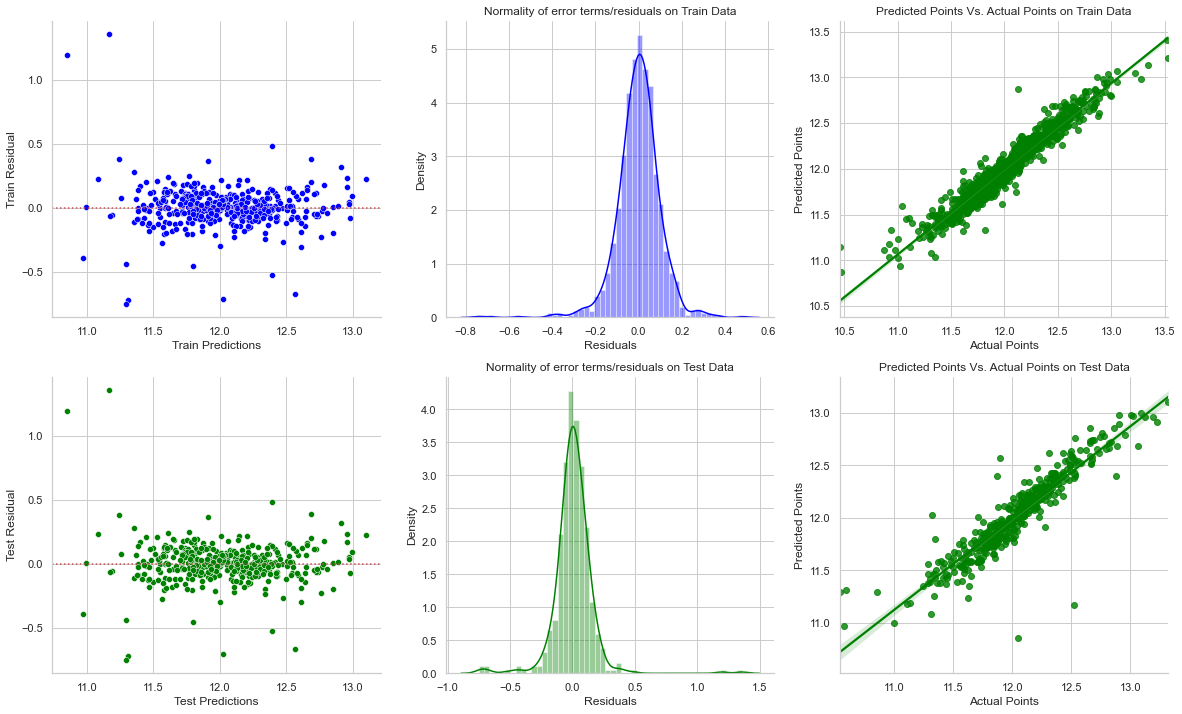

In [66]:
lm = LinearRegression()
lm.fit(X_train, y_train)
lm_metric=prediction_matrix(lm,X_train,X_test,y_train,y_test)

#### iii. RFE Implementation for feature selection

Optimal number of features : 55


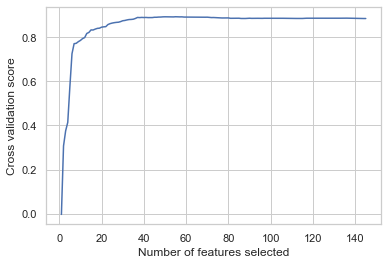

In [67]:
#cross_validation(X_train,y_train,lm)
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=Ridge(), step=1, cv=10,
              scoring='r2',
              min_features_to_select=min_features_to_select)
rfecv.fit(X_train, y_train)
print("Optimal number of features : %d" % rfecv.n_features_)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

In [68]:
col = X_train.columns[rfecv.support_]
len(list(col))

55

**Analysis** - Post RFE feature selection - 90 features to start with

In [69]:
### selecting columns post rfe
X_train_rfe = X_train[col]
X_test_rfe  = X_test[col]

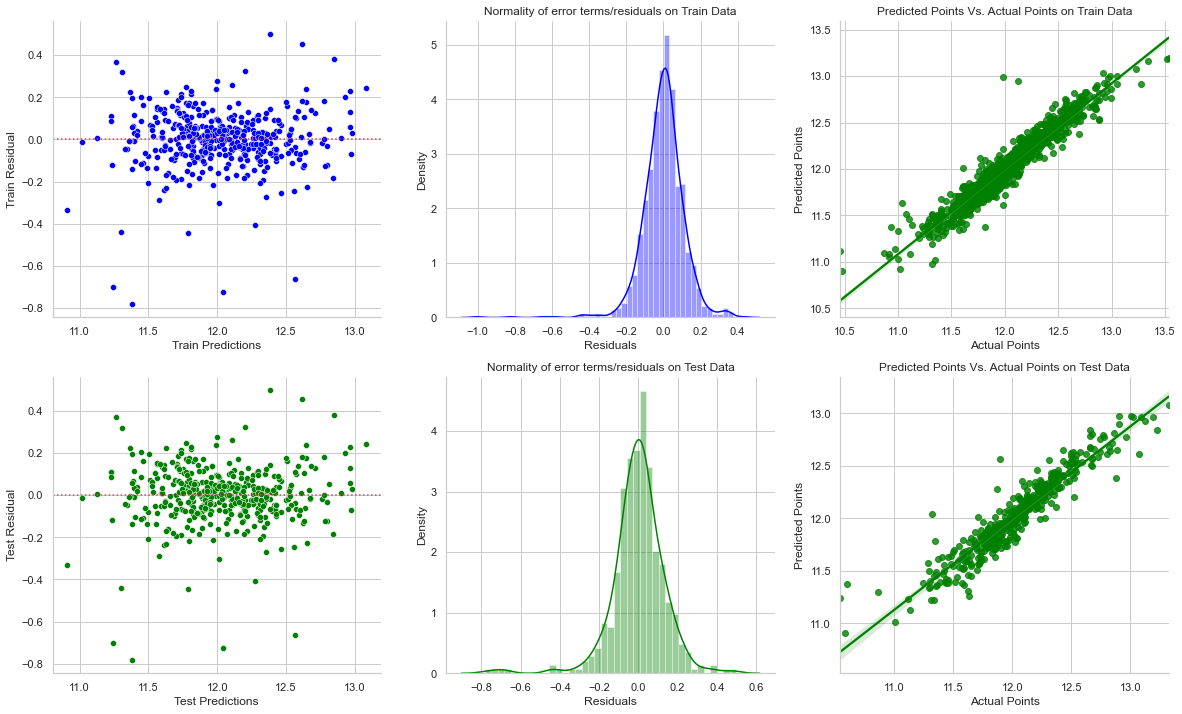

In [70]:
lm_rfe=LinearRegression()
lm_rfe.fit(X_train_rfe,y_train)
lm_rfe_metric=prediction_matrix(lm_rfe,X_train_rfe,X_test_rfe,y_train,y_test)

### Step 6: Regualization using Ridge and Lasso

#### Ridge Regression

Fitting 5 folds for each of 11 candidates, totalling 55 fits


{'alpha': 1.0}

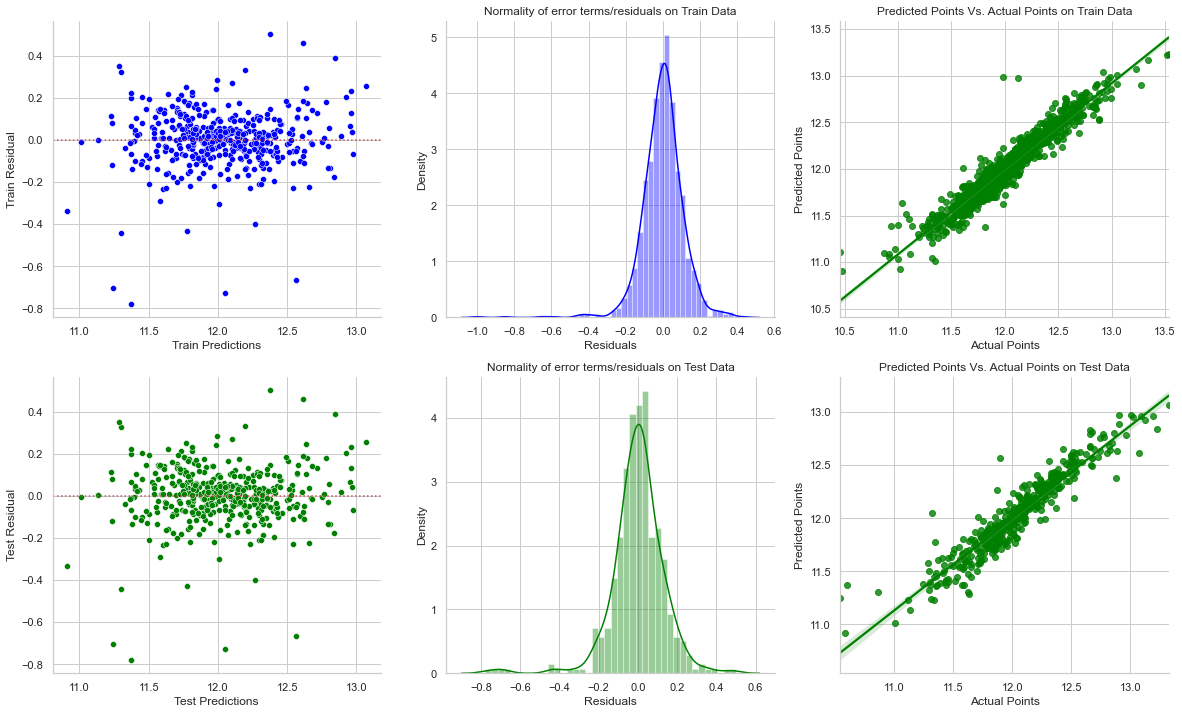

In [71]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.001, 0.01, 0.1, 1.0,10.0,20,50,100,150,200,500]}
estimator = Ridge()
# cross validation
folds = 5
model_cv = GridSearchCV(estimator = estimator, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train_rfe, y_train) 
display(model_cv.best_params_)
alpha = model_cv.best_params_['alpha']
ridge = Ridge(alpha=alpha)
ridge.fit(X_train_rfe, y_train)
lm_ridge_metric=prediction_matrix(ridge,X_train_rfe,X_test_rfe,y_train,y_test)


### Lasso Regression

Fitting 5 folds for each of 13 candidates, totalling 65 fits


{'alpha': 0.001}

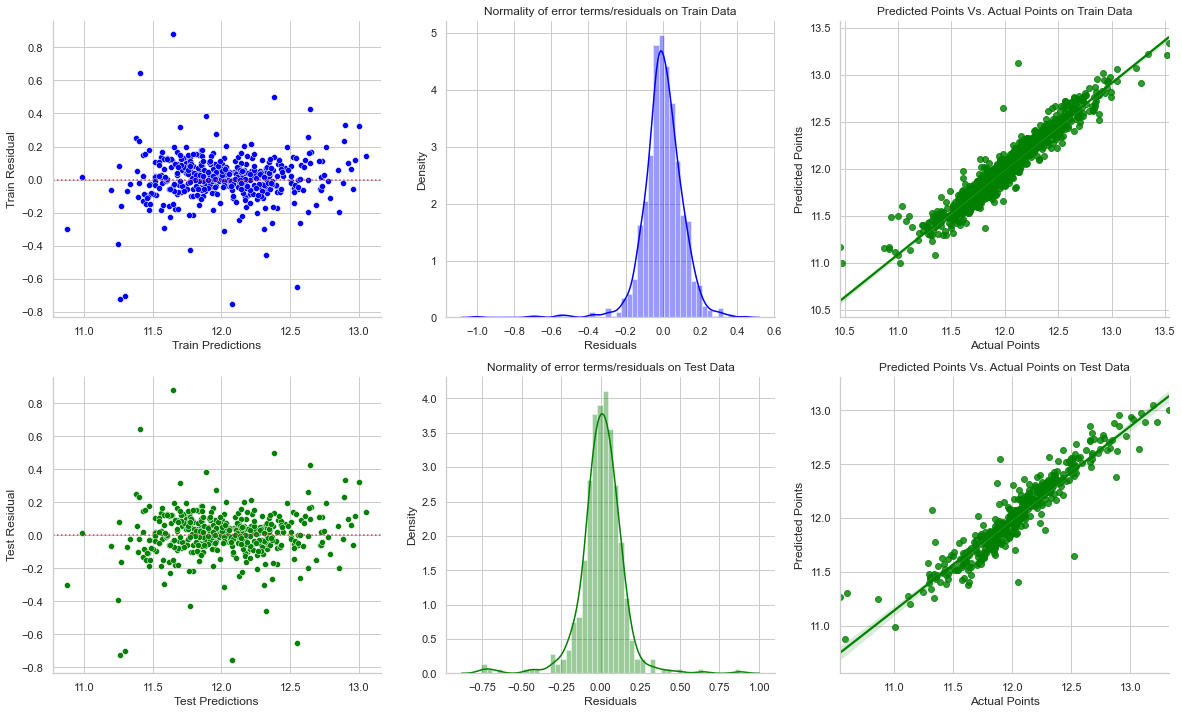

In [72]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.00001,0.0001,0.001, 0.01, 0.1, 1.0,10.0,20,50,100,150,200,500]}
#params = {'alpha': [0.001, 0.0001, 0.0005, 0.005,0.003 ]}
estimator = Lasso()
# cross validation
folds = 5
model_cv = GridSearchCV(estimator = estimator, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 
display(model_cv.best_params_)
alpha = model_cv.best_params_['alpha']
lasso = Lasso(alpha=alpha)
lasso.fit(X_train, y_train) 
lm_lasso_metric=prediction_matrix(lasso,X_train,X_test,y_train,y_test)

In [73]:
# Creating a table which contain all the metrics
lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','Adjusted R2 Score (Train)','Adjusted R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'RMSE (Train)','RMSE (Test)'], 
        'Linear Regression': lm_metric
        }

metric_lm = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )
metric_lm_rfe = pd.Series(lm_rfe_metric,name = 'RFE Linear Regression')
metric_lm_ridge = pd.Series(lm_ridge_metric, name = 'Ridge Regression')
metric_lm_lasso = pd.Series(lm_lasso_metric, name = 'Lasso Regression')
final_metric = pd.concat([metric_lm,metric_lm_rfe,metric_lm_ridge,metric_lm_lasso], axis = 1)
print("Baseline Metric:R-Square")
display(baseline_metric)
print("Model Peformance Metric:")
display(final_metric)

Baseline Metric:R-Square


Metric                Train                 Test
0  LR                    0.87                 0.81
1  Lasso                 0.02                -0.02
2  Ridge                 0.88                 0.85

Model Peformance Metric:


Metric    Linear Regression  RFE Linear Regression  \
0  R2 Score (Train)                          0.94                 0.92     
1  R2 Score (Test)                           0.85                 0.89     
2  Adjusted R2 Score (Train)                 0.92                 0.91     
3  Adjusted R2 Score (Test)                  0.77                 0.87     
4  RSS (Train)                              10.34                12.92     
5  RSS (Test)                                0.03                 0.02     
6  RMSE (Train)                              0.10                 0.11     
7  RMSE (Test)                               0.16                 0.14     

      Ridge Regression     Lasso Regression  
0                 0.92                 0.92  
1                 0.89                 0.88  
2                 0.91                 0.91  
3                 0.87                 0.82  
4                12.99                12.38  
5                 0.02                 0.02  
6                 0.11                 0.11  
7                 0.14                 0.14

**Analysis** - 
1. Model Performance has improved compared to baseline performance
2. Ridge and Lasso are best performer. Based on R-2Score/RMSE value, Ridge will be preferred

#### Lets observe the changes in the coefficients after regularization

In [74]:
betas_ridge = pd.DataFrame(X_train_rfe.columns,columns=["Features"])
betas_ridge.rows = X_train_rfe.columns
betas_ridge['Ridge'] = ridge.coef_
betas = pd.DataFrame(X_train.columns,columns=["Features"])
betas.rows = X_train_rfe.columns
betas['Linear'] = lm.coef_
betas['Lasso'] = lasso.coef_
final_betas=betas.merge(betas_ridge,how="left",on="Features")
final_betas.sort_values(by=['Lasso'],ascending=False).head(100)

Features               Linear  \
115  GrLivArea                                       0.21   
22   Neighborhood_Somerst                            0.02   
110  TotalBsmtSF                                     0.11   
97   OverallQual                                     0.05   
123  TotRmsAbvGrd                                    0.13   
66   CentralAir_Y                                    0.05   
98   OverallCond                                     0.05   
30   Exterior1st_BrkFace                             0.07   
143  Spaciousness                                    0.10   
4    MSZoning_RL                                     0.04   
144  MedNhbdArea                                     0.04   
12   Neighborhood_Crawfor                            0.02   
124  Functional                                      0.06   
116  BsmtFullBath                                    0.04   
128  GarageCars                                      0.02   
17   Neighborhood_NridgHt                           -0.04   
125  Fireplaces                                      0.02   
54   Exterior2nd_VinylSd                             0.10   
84   MoSold_May                                      0.03   
106  BsmtFinSF1                                     -0.04   
132  WoodDeckSF                                      0.02   
7    LotConfig_CulDSac                               0.03   
92   LotArea                                         0.01   
129  GarageArea                                      0.01   
81   MoSold_Jul                                      0.01   
67   GarageType_Attchd                               0.06   
35   Exterior1st_MetalSd                            -0.00   
61   Foundation_PConc                                0.03   
112  1stFlrSF                                       -0.15   
101  ExterCond                                       0.01   
76   Electrical_SBrkr                                0.01   
118  FullBath                                        0.02   
131  GarageCond                                      0.00   
91   LotFrontage                                     0.00   
119  HalfBath                                        0.02   
130  GarageQual                                      0.00   
133  OpenPorchSF                                     0.01   
120  BedroomAbvGr                                    0.00   
103  BsmtCond                                        0.00   
135  3SsnPorch                                       0.00   
93   LotShape                                        0.00   
136  ScreenPorch                                     0.00   
134  EnclosedPorch                                   0.00   
75   PavedDrive_Y                                    0.01   
1    MSSubClass_1-STORY PUD                          0.02   
71   GarageType_Detchd                               0.05   
70   GarageType_CarPort                             -0.01   
77   MoSold_Aug                                     -0.01   
142  LivLotRatio                                    -0.24   
78   MoSold_Dec                                      0.00   
79   MoSold_Feb                                     -0.00   
80   MoSold_Jan                                      0.01   
141  GarageAge                                      -0.02   
117  BsmtHalfBath                                    0.01   
82   MoSold_Jun                                      0.00   
83   MoSold_Mar                                     -0.02   
85   MoSold_Nov                                     -0.01   
87   MoSold_Sep                                     -0.00   
88   Alley_Others                                    0.01   
90   MiscFeature_Others                             -0.02   
94   Utilities                                      -0.19   
95   LandSlope                                       0.02   
96   HouseStyle                                      0.02   
100  ExterQual                                       0.00   
69   GarageType_BuiltIn                              0.05   
10

In [75]:
ridge_sorted_betas=final_betas.sort_values(by=['Ridge'],ascending=False).head(20)
lasso_sorted_betas=final_betas.sort_values(by=['Lasso'],ascending=False).head(20)
plot_bar_chart(ridge_sorted_betas,"Features","Ridge")
plot_bar_chart(lasso_sorted_betas,"Features","Lasso")